# Imports

In [1]:
# Suprress warnings
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Standard imports
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import matplotlib.cm as cm
    import numpy as np

    # Drake imports
    from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
    import pydrake
    from pydrake.all import LogOutput, DirectCollocation, DirectTranscription, MathematicalProgram, InputPortSelection
    from pydrake.all import FindResourceOrThrow
    
    import scipy.interpolate
# Imports of other project files
from log_wrapper import LogWrapper
import controller
import manipulator
import constants
import pedestal
from paper import Paper

from pydrake.all import (MultibodyPlant, Parser, DiagramBuilder, Simulator, RigidTransform,
                         PlanarSceneGraphVisualizer, SceneGraph, TrajectorySource,
                         SnoptSolver, MultibodyPositionToGeometryPose, PiecewisePolynomial,
                         MathematicalProgram, JacobianWrtVariable, eq, RollPitchYaw, AutoDiffXd, BodyIndex,
                        RotationMatrix, Meshcat,MeshcatVisualizerParams, MeshcatVisualizerCpp, MeshcatVisualizer)

# Other imports
import importlib

In [2]:
from IPython.display import display, SVG
import pydot

In [3]:
# Matplotlib configuring
# USE FOR PAPER
# plt.style.use(['science', 'no-latex'])
# font = {'size'   : 14}
# matplotlib.rc('font', **font)
# default_figsize = (2*3,2*2)
# USE GENERALLY
font = {'size'   : 16}
matplotlib.rc('font', **font)
default_figsize = (16,8)

## Meshcat init (including link for new meshcat)

In [4]:
if constants.USE_NEW_MESHCAT:
    meshcat = Meshcat()
    web_url = meshcat.web_url()
else:
    proc, zmq_url, web_url = start_zmq_server_as_subprocess()

# Simulation setup
## Pre-finalize steps

In [5]:
builder = pydrake.systems.framework.DiagramBuilder()

jnt_frc_log = []
manipulator_acc_log = []
manipulator_acc_log.append(np.zeros(7))

# Add all elements
plant, scene_graph = pydrake.multibody.plant.AddMultibodyPlantSceneGraph(builder, time_step=constants.DT)
v_stiction=1e-3
plant.set_stiction_tolerance(v_stiction)
plant.set_penetration_allowance(0.001)
pedestal_instance = pedestal.AddPedestal(plant)

# These joint angles start the paper approximately the right spot, no matter how many links are used
num_links = 2
def_joint_angles = 0

paper = Paper(plant, scene_graph, num_links, default_joint_angle=def_joint_angles,
              stiffness=2.5e-1,
              damping=1e-1)
paper.weld_paper_edge(pedestal.PEDESTAL_WIDTH, pedestal.PEDESTAL_HEIGHT)

Calculate link inertia to use in damping calculations:

In [6]:
manipulator_instance = manipulator.data["add_plant_function"](plant, scene_graph)

In [7]:
# Set up logger (needs to happen after all bodies are added)
contact_body = plant.GetBodyByName(manipulator.data["contact_body_name"])
log_wrapper = LogWrapper(plant.num_bodies(), int(contact_body.index()), paper, jnt_frc_log, manipulator_acc_log)
builder.AddSystem(log_wrapper)

## Controller selection

In [8]:
ll_idx = paper.link_idxs[-1]
contact_body_idx = int(contact_body.index())

In [9]:
I_L = plant.get_body(
    BodyIndex(paper.link_idxs[-1])).default_rotational_inertia().CalcPrincipalMomentsOfInertia()[0]
sys_params = {
    'I_L': I_L,
    'v_stiction': v_stiction,
    'w_L': paper.link_width,
    'm_L': paper.link_mass,
    'b_J': paper.damping,
    'k_J': paper.stiffness,
    'g': plant.gravity_field().gravity_vector()[-1]*-1,
}
fold_ctrl = controller.FoldingController(
    ll_idx=int(paper.link_idxs[-1]),
    contact_body_idx=contact_body_idx,
    sys_params=sys_params,
    jnt_frc_log=jnt_frc_log,
    options={
        'use_friction_adaptive_ctrl': False,
        'use_friction_robust_adaptive_ctrl': False,
    },
    manipulator_acc_log=manipulator_acc_log,
)

## Post-finalize steps

In [10]:
plant.Finalize()

In [11]:
## Post finalize steps
# Add logger
builder.Connect(plant.get_body_poses_output_port(), log_wrapper.get_input_port(0))
builder.Connect(plant.get_body_spatial_velocities_output_port(), log_wrapper.get_input_port(1))
builder.Connect(plant.get_body_spatial_accelerations_output_port(), log_wrapper.get_input_port(2)) 
builder.Connect(plant.get_contact_results_output_port(), log_wrapper.get_input_port(3))
builder.Connect(plant.get_reaction_forces_output_port(), log_wrapper.get_input_port(4))
builder.Connect(plant.get_generalized_acceleration_output_port(manipulator_instance), log_wrapper.get_input_port(5))
builder.Connect(plant.get_state_output_port(manipulator_instance), log_wrapper.get_input_port(6))

# Add arm controller
builder.AddSystem(fold_ctrl)
builder.Connect(plant.get_state_output_port(manipulator_instance), fold_ctrl.get_input_port(0))
builder.Connect(plant.get_body_poses_output_port(), fold_ctrl.get_input_port(1))
builder.Connect(plant.get_body_spatial_velocities_output_port(), fold_ctrl.get_input_port(2))
builder.Connect(plant.get_contact_results_output_port(), fold_ctrl.get_input_port(3))

builder.Connect(fold_ctrl.get_output_port(), plant.get_actuation_input_port())

# Visualization and logging
logger = LogOutput(log_wrapper.get_output_port(), builder)

if constants.USE_NEW_MESHCAT:
    params = MeshcatVisualizerParams()
    vis = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph.get_query_output_port(), meshcat, params)
    fold_ctrl.set_meshcat(meshcat)
else:
    vis = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(builder, scene_graph)
    # vis.set_planar_viewpoint(camera_position=[1, 0, 0], xmin=-0.3, xmax=0.3, ymin=-0.3, ymax=0.3)

# Build diagram and do actions requiring 
diagram = builder.Build()
diagram_context = diagram.CreateDefaultContext()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.


## Meschat link for old meschat

In [12]:
manipulator.data['set_positions'](diagram, diagram_context, plant, manipulator_instance)

In [13]:
# SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())

# Run simulation

In [14]:
# Finalize simulation and visualization
simulator = pydrake.systems.analysis.Simulator(diagram, diagram_context)
simulator.Initialize()
if not constants.USE_NEW_MESHCAT:
    vis.start_recording()
try:
    simulator.AdvanceTo(constants.TSPAN)
except RuntimeError as e:
    print(e)
except np.linalg.LinAlgError as e:
    print(e)

[2021-11-02 12:02:00.793] [console] [warning] Currently MultibodyPlant does not handle joint limits for continuous models. However some joints do specify limits. Consider setting a non-zero time step in the MultibodyPlant constructor; this will put the plant in discrete-time mode, which does support joint limits. Joints that specify limits are: 'sphere_x_translation', 'sphere_y_translation', 'sphere_z'


In [15]:
# This way, we can use the actual time the simulation ran for
effective_tspan = max(logger.sample_times())
print("effective_tspan:", effective_tspan)

if not constants.USE_NEW_MESHCAT:
    vis.stop_recording()
    vis.publish_recording()

effective_tspan: 10.0


# Plots used in orginal paper

In [16]:
# This script is getting huge. We need to turn off parts that we're not using.
generate_paper_plots = False

In [17]:
if generate_paper_plots:
    # Generate plots for paper
    nb = plant.num_bodies()
    y_traces = []
    z_traces = []
    theta_traces = []
    for b in paper.link_idxs:
        y_traces.append(logger.data()[log_wrapper.entries_per_body*b+1])
        z_traces.append(logger.data()[log_wrapper.entries_per_body*b+2])
        theta_traces.append(logger.data()[log_wrapper.entries_per_body*b+3])
    y_traces = np.array(y_traces)
    z_traces = np.array(z_traces)
    theta_traces = np.array(theta_traces)

    times_ = np.arange(0,effective_tspan, effective_tspan/10)
    cmap = cm.get_cmap("viridis_r")
    plt.figure(figsize=(2*3,2*2))
    for t in times_:
        c = cmap(t/effective_tspan)
        idx = np.argmax(logger.sample_times() >= t)

        # Plot paper
        # PROGRAMMING: Account for paper thickness in plots
        for y, z, theta in zip(y_traces[:,idx], z_traces[:,idx], theta_traces[:,idx]):
            y0 = y - np.cos(theta)*paper.link_width/2
            z0 = z - np.sin(theta)*paper.link_width/2
            y1 = y + np.cos(theta)*paper.link_width/2
            z1 = z + np.sin(theta)*paper.link_width/2
            plt.plot([y0, y1], [z0, z1], color=c)


        # Plot manipulator
        plt.scatter(logger.data()[log_wrapper.entries_per_body*contact_body_idx+1,idx], 
                    logger.data()[log_wrapper.entries_per_body*contact_body_idx+2,idx],
                    color=c, s=300, zorder=1)

    xlim = plt.xlim()
    ylim = plt.ylim()
    plt.scatter([xlim[0]-50, xlim[0]-50], [ylim[0]-50, ylim[0]-50], c=[0, effective_tspan], cmap=cmap)
    plt.xlim(xlim)
    plt.ylim(ylim)
    cb = plt.colorbar()
    cb.set_label("Time")
    plt.xlabel("$y$ position")
    plt.ylabel("$z$ position")
    plt.show()

# Drag plots

This is a sanity check to see how much force we're neglecting by ignoring drag. The colored lines are the drag forces at each link, and the dashed black line is the force due to gravity for scale.

Note that the formula for drag force is $\rho v^2 C_d A_{paper}$.

$C_d$ comes from [this site](https://www.engineersedge.com/fluid_flow/rectangular_flat_plate_drag_14036.htm), which says it depends on $L/d$. For 20 links, $L/d\approx15$. Rounding this down to 10, we get $C_d=1.22$.

In [18]:
generate_drag_plots = False

In [19]:
if generate_drag_plots:
    # Plot drag forces
    plt.figure(figsize=(16, 12))
    nb = plant.num_bodies
    vel_traces = []
    for b in paper.link_idxs:
        rho = 1.225
        C_d = paper.link_width*paper.depth
        vel_sqred = logger.data()[log_wrapper.entries_per_body*b+7]**2+logger.data()[log_wrapper.entries_per_body*b+8]**2
        f = 0.5*rho*C_d*vel_sqred
        plt.plot(f)

    plt.axhline(paper.link_mass*9.81, color='black', linestyle='--')
    plt.show()

# Verifying equations hold
We have the following free body diagrams:
<img src="forces.png" width=400px>
<img src="link-moments.png" width=400px>

Which give us the following equations:
$$
\begin{aligned}
     m_La_{LT} &= F_{FL} + F_{GT} +F_{OT} \\
    m_La_{LN} &= F_{NL} + F_{GN} +F_{ON} \\
    m_Ma_{MT} &= F_{FM} + F_{CT} \\
    m_Ma_{MN} &= F_{NM} + F_{CN} \\
    a_{LT} &= a_{MT} \\
    a_{LN} &= a_{MN} \\
    a_{LT} &= -\frac{w_L}{2}\dot\theta^2 \\
    a_{LN} &= \frac{w_L}{2}\ddot\theta \\
    I_L\ddot\theta &= \frac{w_L}{2}F_{ON}- \frac{h_L}{2}F_{FL} - r_TF_{NL} \\
    F_{NL} &= -F_{NM} \\
    F_{FL} &= -F_{FM} \\
    a_{NL} &= a_{Nd}  \\
    F_{FL} &= 0
\end{aligned}
$$
For each of these equations, I want to plot the value on the left side and the value on the right side to see if they match.

# Loading signals
Preparing all the signals we'll need.

In [20]:
debug = fold_ctrl.debug

In [21]:
min_key_length = np.inf
for k in debug.keys():
    if len(debug[k]) > 0 and len(debug[k]) < min_key_length:
        min_key_length = len(debug[k])
for k in debug.keys():
    debug[k] = debug[k][:min_key_length]

In [22]:
l_times = logger.sample_times()
d_times = np.array(debug['times'])

## Helper functions

In [23]:
def diff_vec(vec):
    d_vec = np.diff(vec, axis=0)
    for i in range(vec.shape[1]):
        d_vec[:, i] /= np.expand_dims(np.diff(l_times), 1)
    d_vec = np.concatenate((d_vec, [d_vec[-1]]))
    return d_vec

In [24]:
def plot_vec(sig1, sig1_label, sig2, sig2_label, finish_plotting=True, plot_x=True, start_time=None):
    if start_time is None:
        idx_start_ = idx_start
    else:
        idx_start_ = np.argmax(l_times > start_time)
    plt.figure(figsize=(16, 8))
    lw = 5
    if plot_x:
        plt.plot(l_times[idx_start_:idx_end], sig1[:,0][idx_start_:idx_end], label=sig1_label + r' $\hat x$ component', color='pink', linewidth=lw)
    plt.plot(l_times[idx_start_:idx_end], sig1[:,1][idx_start_:idx_end], label=sig1_label + r' $\hat y$ component', color='lightgreen', linewidth=lw)
    plt.plot(l_times[idx_start_:idx_end], sig1[:,2][idx_start_:idx_end], label=sig1_label + r' $\hat z$ component', color='lightskyblue', linewidth=lw)
    
    if plot_x:
        plt.plot(l_times[idx_start_:idx_end], sig2[:,0][idx_start_:idx_end], label=sig2_label + r' $\hat x$ component', color='red', linewidth=lw, linestyle='--')
    plt.plot(l_times[idx_start_:idx_end], sig2[:,1][idx_start_:idx_end], label=sig2_label + r' $\hat y$ component', color='green', linewidth=lw, linestyle='--')
    plt.plot(l_times[idx_start_:idx_end], sig2[:,2][idx_start_:idx_end], label=sig2_label + r' $\hat z$ component', color='blue', linewidth=lw, linestyle='--')
    plt.xlabel("Time (seconds)")
    plt.legend()
    plt.autoscale(enable=True, axis='x', tight=True)
    if finish_plotting:
        plt.show()

In [25]:
def plot_vec_XTN(sig1, sig1_label, sig2, sig2_label, finish_plotting=True, plot_x=True, start_time=None):
    if start_time is None:
        idx_start_ = idx_start
    else:
        idx_start_ = np.argmax(l_times > start_time)
    plt.figure(figsize=(16, 8))
    lw = 5
    
    T_proj1 = np.matmul(T(sig1), T_hat).flatten()
    T_proj2 = np.matmul(T(sig2), T_hat).flatten()
    N_proj1 = np.matmul(T(sig1), N_hat).flatten()
    N_proj2 = np.matmul(T(sig2), N_hat).flatten()
    
    plt.plot(l_times[idx_start_:idx_end], sig1[:,0][idx_start_:idx_end], label=sig1_label + r' $\hat x$ component', color='pink', linewidth=lw)
    plt.plot(l_times[idx_start_:idx_end], T_proj1[idx_start_:idx_end], label=sig1_label + r' $\hat T$ component', color='lightgreen', linewidth=lw)
    plt.plot(l_times[idx_start_:idx_end], N_proj1[idx_start_:idx_end], label=sig1_label + r' $\hat N$ component', color='lightskyblue', linewidth=lw)
    
    plt.plot(l_times[idx_start_:idx_end], sig2[:,0][idx_start_:idx_end], label=sig2_label + r' $\hat x$ component', color='red', linewidth=lw, linestyle='--')
    plt.plot(l_times[idx_start_:idx_end], T_proj2[idx_start_:idx_end], label=sig2_label + r' $\hat T$ component', color='green', linewidth=lw, linestyle='--')
    plt.plot(l_times[idx_start_:idx_end], N_proj2[idx_start_:idx_end], label=sig2_label + r' $\hat N$ component', color='blue', linewidth=lw, linestyle='--')
    plt.xlabel("Time (seconds)")
    plt.legend()
    plt.autoscale(enable=True, axis='x', tight=True)
    if finish_plotting:
        plt.show()

In [26]:
def diff_arr(arr):
    d_arr = np.diff(arr)/np.diff(l_times)
    d_arr = np.concatenate((d_arr, [d_arr[-1]]))
    return d_arr

In [27]:
# Friction helper functions
def step5(x):
    '''Python version of MultibodyPlant::StribeckModel::step5 method'''
    x3 = x * x * x
    return x3 * (10 + x * (6 * x - 15))

def stribeck(us, uk, v):
    '''
    Python version of MultibodyPlant::StribeckModel::ComputeFrictionCoefficient
    
    From
    https://github.com/RobotLocomotion/drake/blob/b09e40db4b1c01232b22f7705fb98aa99ef91f87/multibody/plant/images/stiction.py
    '''
    u = np.zeros_like(v) + uk
    u[v < 1] = us * step5(v[v < 1])
    mask = (v >= 1) & (v < 3)
    u[mask] = us - (us - uk) * step5((v[mask] - 1) / 2)
    return u

In [28]:
def T(vec):
    return np.transpose(vec, [0, 2, 1])

## Inputs
These should all come from simulation/geometry, since they are inputs to the controller and are "fixed" from the controller's perspective.

In [29]:
nq = manipulator.data['nq']

### Geometric quantities ($m_L, m_M, w_L, I_L, h_L, \mu$)

In [30]:
m_L = paper.link_mass
w_L = paper.link_width
I_L = paper.plant.get_body(
    BodyIndex(paper.link_idxs[-1])).default_rotational_inertia().CalcPrincipalMomentsOfInertia()[0]
h_L = paper.height
mu_paper = constants.FRICTION
mu = 2*mu_paper/(1+mu_paper) # 2μₘμₙ/(μₘ + μₙ)
b_J = paper.damping
k_J = paper.stiffness

### Gravity, unit vectors ($F_{GT}, F_{GN}, \hat T, \hat N$)

In [31]:
# Assume plane contact, so all N_hat should point the same direction
# TODO: verify all point in the same direction
N_hat_raw = logger.data()[log_wrapper.contact_entry_start_idx+14:log_wrapper.contact_entry_start_idx+17,:].copy() # So it's writeable
N_hat = np.expand_dims(N_hat_raw.T, 2)
N_hat[:,0][np.isnan(N_hat[:,0])] = 0
N_hat[:,1][np.isnan(N_hat[:,1])] = 0
N_hat[:,2][np.isnan(N_hat[:,2])] = 1

In [32]:
T_hat = np.matmul(
    np.array([
        [1,  0, 0],
        [0,  0, 1],
        [0, -1, 0],
    ]),
    N_hat)

It's also useful here to calculate project matrices:

In [33]:
N_hat_proj_mat = np.matmul(N_hat, np.transpose(N_hat, [0, 2, 1]))

In [34]:
g = plant.gravity_field().gravity_vector()[-1]*-1
F_G = np.zeros([l_times.size, 3, 1])
F_G[:,2,0] = -np.ones_like(l_times)*g*m_L
F_GT = np.matmul(T(F_G), T_hat).flatten()
F_GN = np.matmul(T(F_G), N_hat).flatten()

In [35]:
tau_g_no_interp = np.array(fold_ctrl.debug['tau_g'])
tau_g = np.expand_dims(scipy.interpolate.interp1d(fold_ctrl.debug['times'], tau_g_no_interp, axis=0)(l_times), 2)

/usr/local/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


### Positions, velocities ($\dot\theta^2, r_T, \dot d_T$)

#### Object poses & vels

In [36]:
idx = log_wrapper.get_idx("pos", "trn", ll_idx)
length = 3
p_L = np.expand_dims(logger.data()[idx:idx+length].T, 2)
p_LN = np.matmul(T(p_L), N_hat).flatten()
p_LT = np.matmul(T(p_L), T_hat).flatten()
p_LX = p_L[:,0].flatten()

In [37]:
theta_L = logger.data()[log_wrapper.get_idx("pos", "rot", ll_idx)]
theta_M = logger.data()[log_wrapper.get_idx("pos", "rot", contact_body_idx)]

In [38]:
d_theta_L = logger.data()[log_wrapper.get_idx("vel", "rot", ll_idx)]
d_theta_M = logger.data()[log_wrapper.get_idx("vel", "rot", contact_body_idx)]

In [39]:
x_hat = np.zeros((len(l_times), 3, 1))
x_hat[:,0,:] = 1

y_hat = np.zeros((len(l_times), 3, 1))
y_hat[:,1,:] = 1

z_hat = np.zeros((len(l_times), 3, 1))
z_hat[:,2,:] = 1

In [40]:
idx = log_wrapper.get_idx("vel", "trn", ll_idx)
length = 3
v_L = np.expand_dims(logger.data()[idx:idx+length].T,2)
v_LN = np.matmul(T(v_L), N_hat).flatten()
v_LT = np.matmul(T(v_L), T_hat).flatten()
v_LX = v_L[:,0].flatten()

In [41]:
idx = log_wrapper.get_idx("pos", "trn", contact_body_idx)
length = 3
p_M = np.expand_dims(logger.data()[idx:idx+length].T, 2)
p_MN = np.matmul(T(p_M), N_hat).flatten()
p_MT = np.matmul(T(p_M), T_hat).flatten()
p_MX = p_M[:,0].flatten()

In [42]:
idx = log_wrapper.get_idx("vel", "trn", contact_body_idx)
length = 3
v_M = np.expand_dims(logger.data()[idx:idx+length].T, 2)
v_MN = np.matmul(T(v_M), N_hat).flatten()
v_MT = np.matmul(T(v_M), T_hat).flatten()
v_MX = v_M[:,0].flatten()

#### Manipulator eq. terms

In [43]:
J_no_interp = np.array(fold_ctrl.debug['J'])
J = scipy.interpolate.interp1d(fold_ctrl.debug['times'], J_no_interp, axis=0)(l_times)
J_rotational = J[:,:3,:]
J_translational = J[:,3:,:]

In [44]:
joint_centering_torque = scipy.interpolate.interp1d(
    d_times, 
    np.array(fold_ctrl.debug['joint_centering_torque']),
    axis=0)(l_times)

In [45]:
q = np.expand_dims((logger.data()[log_wrapper.state_start_idx:log_wrapper.state_start_idx + nq,:]).T, 2)
d_q = np.expand_dims((logger.data()[log_wrapper.state_start_idx + nq:log_wrapper.state_start_idx + nq*2,:]).T, 2)

In [46]:
M_no_interp = np.array(fold_ctrl.debug['M'])
M = scipy.interpolate.interp1d(fold_ctrl.debug['times'], M_no_interp, axis=0)(l_times)

In [47]:
Cv_no_interp = np.array(fold_ctrl.debug['C']) # TODO fix this name
Cv = np.expand_dims(scipy.interpolate.interp1d(fold_ctrl.debug['times'], Cv_no_interp, axis=0)(l_times), 2)

#### Body derived terms
Meaning terms derived from the positions/velocities of bodies

In [48]:
R = np.zeros((len(l_times), 3, 3))
R[:,1,1] = np.cos(theta_L)
R[:,1,2] = -np.sin(theta_L)
R[:,2,1] = np.sin(theta_L)
R[:,2,2] = np.cos(theta_L)

In [49]:
T_hat_geo = np.matmul(R, y_hat)
N_hat_geo = np.matmul(R, z_hat)

In [50]:
# Link edge
p_LE = p_L + (w_L/2)*T_hat-(h_L/2)*N_hat

In [51]:
omega_vec_L = np.expand_dims(np.vstack((d_theta_L, np.zeros_like(d_theta_L), np.zeros_like(d_theta_L))).T, 2)
idx = log_wrapper.get_idx("vel", "rot", contact_body_idx)
length = 3
omega_vec_M = np.expand_dims(logger.data()[idx:idx+length].T, 2)

In [52]:
J_dot = diff_vec(J)

#### Contact terms
TODO: edit out/simplify eventually

In [53]:
contact_point = logger.data()[log_wrapper.contact_entry_start_idx+11:log_wrapper.contact_entry_start_idx+14,:]

In [54]:
p_C = np.expand_dims(contact_point.T, 2)
p_CT = np.matmul(T(p_C), T_hat).flatten()
p_CN = np.matmul(T(p_C), N_hat).flatten()

In [55]:
r = np.linalg.norm(p_C - p_M, axis=1).flatten()

In [56]:
# Assume all the slip speeds are the same
# TODO: verify
slip_speed = logger.data()[log_wrapper.contact_entry_start_idx+10,:]

In [57]:
# d vector
d_vec = p_C - p_LE
d_T = np.matmul(T(d_vec), T_hat).flatten()
d_N = np.matmul(T(d_vec), N_hat).flatten()
d_X = d_vec[:,0].flatten()

In [58]:
d_d_T = -d_theta_L*h_L/2-d_theta_L*r - v_LT + v_MT + d_theta_L*d_N
d_d_N = -d_theta_L*w_L/2-v_LN+v_MN-d_theta_L*d_T
d_d_X = diff_arr(d_X)

In [59]:
dd_d_T = diff_arr(d_d_T)
dd_d_N = diff_arr(d_d_N)
dd_d_X = diff_arr(d_d_X)

In [60]:
d_d_vec = diff_vec(d_vec)
d_d_vec_T = np.matmul(T(d_d_vec), T_hat).flatten()
d_d_vec_N = np.matmul(T(d_d_vec), N_hat).flatten()

In [61]:
p_MConM = p_C - p_M
p_LConL = p_C - p_L

v_WConM = v_M + np.cross(omega_vec_M, p_MConM, axis=1)
v_WConL = v_L + np.cross(omega_vec_L, p_LConL, axis=1)

v_S_raw = v_WConM - v_WConL
v_S_N = np.matmul(N_hat_proj_mat, v_S_raw)
v_S = v_S_raw - v_S_N
v_S = v_S_raw - v_S_N
s_S = np.linalg.norm(v_S, axis=1).flatten()

In [62]:
s_hat = v_S/np.expand_dims(np.linalg.norm(v_S, axis=1), 2)
s_hat_X = s_hat[:,0].flatten()
s_hat_T = np.matmul(T(s_hat), T_hat).flatten()

In [63]:
d_d_T_diff = diff_arr(d_T)
d_d_N_diff = diff_arr(d_N)

### Friction coeficients

In [64]:
mu_S = stribeck(1, 1, slip_speed/v_stiction)

## Outputs
These should all come directly from simulation, except for control forces.
### Measured accelerations ($a_{LT}, a_{LN}, a_{MT}, a_{MN}, \ddot\theta$)

In [65]:
idx = log_wrapper.get_idx("acc", "trn", ll_idx)
length = 3
a_L = np.expand_dims(logger.data()[idx:idx+length].T, 2)
a_LX = np.matmul(T(a_L), x_hat).flatten()
a_LT = np.matmul(T(a_L), T_hat).flatten()
a_LN = np.matmul(T(a_L), N_hat).flatten()

In [66]:
idx = log_wrapper.get_idx("acc", "trn", contact_body_idx)
length = 3
a_M = np.expand_dims(logger.data()[idx:idx+length].T, 2)
a_MT = np.matmul(T(a_M), T_hat).flatten()
a_MN = np.matmul(T(a_M), N_hat).flatten()
a_MX = a_M[:,0].flatten()
a_MY = a_M[:,1].flatten()
a_MZ = a_M[:,2].flatten()

In [67]:
idx = log_wrapper.get_idx("acc", "rot", contact_body_idx)
length = 3
alpha_M = np.expand_dims(logger.data()[idx:idx+length].T, 2)
alpha_MT = np.matmul(T(alpha_M), T_hat).flatten()
alpha_MN = np.matmul(T(alpha_M), N_hat).flatten()
alpha_MX = alpha_M[:,0].flatten()
alpha_MY = alpha_M[:,1].flatten()
alpha_MZ = alpha_M[:,2].flatten()

In [68]:
dd_theta_L = logger.data()[log_wrapper.get_idx("acc", "rot", ll_idx)]
dd_theta_M = logger.data()[log_wrapper.get_idx("acc", "rot", contact_body_idx)]

In [69]:
dd_q = np.expand_dims((logger.data()[log_wrapper.gen_accs_start_idx:
                                     log_wrapper.gen_accs_start_idx+nq,:]).T, 2)

### Contact forces ($F_{NL}, F_{FL}, F_{NM}, F_{FM}$)
Slightly different then just taking normal/tangent projections.

In [70]:
F_NM = np.zeros(len(l_times))
F_FMT = np.zeros(len(l_times))
F_FMX = np.zeros(len(l_times))
tau_contact = np.zeros((len(l_times), nq, 1))
for i in range(log_wrapper.max_contacts):
    # Pull out terms
    start_idx = log_wrapper.contact_entry_start_idx + log_wrapper.entries_per_contact*i
    contact_point = np.expand_dims(logger.data()[start_idx+11:start_idx+14,:].T, 2)
    if np.all(np.isnan(contact_point)):
        break

    # Calculate intermediautes
    lever_arm = contact_point - p_M
    force = np.expand_dims(logger.data()[start_idx+0:start_idx+3,:].T, 2)
    torque = np.cross(lever_arm, force, axis=1)
    wrench = np.hstack((force, torque))
    
    # Calculate updates
    F_FMT_update = np.matmul(T(force), T_hat).flatten()
    F_NM_update = np.matmul(T(force), N_hat).flatten()
    F_FMX_update = force[:,0].flatten()
    
    # Update
    tau_contact += np.matmul(T(J), wrench)
    F_FMT += F_FMT_update
    F_NM += F_NM_update
    F_FMX += F_FMX_update
    
F_NM = np.nan_to_num(F_NM)
F_FMT = np.nan_to_num(F_FMT)
F_FMX = np.nan_to_num(F_FMX)
tau_contact = np.nan_to_num(tau_contact)

In [71]:
F_FLT = -F_FMT
F_FLX = -F_FMX
F_NL = -F_NM

In [72]:
# Equivalent contact forces for each object
F_contact_M = np.expand_dims(F_FMX, [1, 2])*x_hat + \
                  np.expand_dims(F_FMT, [1, 2])*T_hat + \
                  np.expand_dims(F_NM, [1, 2])*N_hat

In [73]:
F_contact_L = np.expand_dims(F_FLX, [1, 2])*x_hat + \
              np.expand_dims(F_FLT, [1, 2])*T_hat + \
              np.expand_dims(F_NL, [1, 2])*N_hat

### Object forces ($F_{ON}, F_{OT}, \tau_O$)

In [74]:
idx = log_wrapper.get_last_jnt_idx("trn")
joint_force_in_compliance_frame = logger.data()[idx:idx+3]

In [75]:
# Copy makes it mutable
F_OX = joint_force_in_compliance_frame[0,:].copy()
F_OT = joint_force_in_compliance_frame[1,:].copy()
F_ON = joint_force_in_compliance_frame[2,:].copy()

In [76]:
F_OX_orig = F_OX.copy()

In [77]:
joint_force_in_compliance_frame[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [78]:
idx = log_wrapper.get_last_jnt_idx("rot")
joint_torque_in_compliance_frame = logger.data()[idx:idx+3]

In [79]:
# Copy makes it mutable
tau_O = joint_torque_in_compliance_frame[0,:].copy()

In [80]:
F_OX = np.nan_to_num(F_OX)
F_OT = np.nan_to_num(
F_OT)
F_ON = np.nan_to_num(
F_ON)
tau_O = np.nan_to_num(
tau_O)

## Control terms

In [81]:
tau_ctrl_no_interp = np.array(fold_ctrl.debug['tau_ctrl'])
tau_ctrl = np.expand_dims(scipy.interpolate.interp1d(fold_ctrl.debug['times'], tau_ctrl_no_interp, axis=0)(l_times), 2)

In [82]:
tau_out_no_interp = np.array(fold_ctrl.debug['tau_out'])
tau_out = np.expand_dims(scipy.interpolate.interp1d(fold_ctrl.debug['times'], tau_out_no_interp, axis=0)(l_times), 2)

In [83]:
F_CX_no_interp = np.array(debug['F_CXs'])
F_CX = scipy.interpolate.interp1d(d_times, F_CX_no_interp, axis=0)(l_times)
F_CT_no_interp = np.array(debug['F_CTs'])
F_CT = scipy.interpolate.interp1d(d_times, F_CT_no_interp, axis=0)(l_times)
F_CN_no_interp = np.array(debug['F_CNs'])
F_CN = scipy.interpolate.interp1d(d_times, F_CN_no_interp, axis=0)(l_times)

In [84]:
F_control = (
    np.expand_dims(F_CT, [1,2])*T_hat
    +
    np.expand_dims(F_CN, [1,2])*N_hat)
F_control[:,0,:] = np.expand_dims(F_CX, 1)

In [85]:
# TODO: remove this
# tau_control_no_grav_comp = np.matmul(JT_trn, F_control)

In [86]:
# tau_control = tau_control_no_grav_comp - tau_g

### Other outputs

In [87]:
mu_hats = np.interp(l_times, d_times, debug['mu_ests'])

In [88]:
forces_found = logger.data()[-1,:]

In [89]:
in_contact_no_interp = np.array(debug['in_contact'])
in_contact = scipy.interpolate.interp1d(fold_ctrl.debug['times'], in_contact_no_interp)(l_times)

In [90]:
raw_in_contact_no_interp = np.array(debug['raw_in_contact'])
raw_in_contact = scipy.interpolate.interp1d(fold_ctrl.debug['times'], raw_in_contact_no_interp)(l_times)

In [91]:
t = l_times

# Plotting settings

In [92]:
lw = 5

## Setting up time

In [93]:
idx_start = np.argmax(in_contact > 0)
t_start = t[idx_start]
t_start

5.501810042733868

In [94]:
first_contact_idx = np.argmax(in_contact)
last_contact_idx = in_contact.size - np.argmax(raw_in_contact[::-1]-1)-1
l_times[last_contact_idx]

5.619082018982508

In [95]:
last_not_in_contact_idx = in_contact.size - np.argmax(np.logical_not(raw_in_contact[::-1])-1)-1
t_start_of_last_contact = 0.14 #t[last_not_in_contact_idx+1]

In [96]:
t_start = t[first_contact_idx] + 0.01
t_end = t[last_contact_idx] - 0.01
idx_start = np.argmax(l_times > t_start)
idx_end = np.argmax(l_times > t_end)
if idx_end == 0:
    idx_end = len(l_times) - 1

## Defining functions

In [97]:
def plot_eq(lhs, lhs_label, rhs, rhs_label, lhs_alpha=1, rhs_alpha=1, lw=5, finish_plotting=True, 
            plot_diff=True, figsize_=None, plot_err_as_pct=False, t_start=t_start, newline_in_title=False, t_end=t_end):
    if figsize_ is not None:
        plt.figure(figsize=figsize_)
    else:
        plt.figure(figsize=default_figsize)
    if isinstance(lhs, float) or isinstance(lhs, int):
        lhs = np.ones_like(l_times)*lhs
    if isinstance(rhs, float) or isinstance(rhs, int):
        rhs = np.ones_like(l_times)*rhs
    idx_start = np.argmax(l_times > t_start)
    idx_end = np.argmax(l_times > t_end)
    if idx_end == 0:
        idx_end = len(l_times) - 1
        
    b = np.broadcast(lhs, rhs)
    if np.count_nonzero(np.array(b.shape) > 1000) > 1:
        raise ValueError("Broadcast shape of lhs and rhs is {}, which is too large.".format(b.shape))
        
    plt.subplot(211)
    error = lhs[idx_start:idx_end]-rhs[idx_start:idx_end]
    if plot_err_as_pct:
        lhs_range = np.nanmax(lhs[idx_start:idx_end]) - np.nanmin(lhs[idx_start:idx_end])
        rhs_range = np.nanmax(rhs[idx_start:idx_end]) - np.nanmin(rhs[idx_start:idx_end])
        
        lhs_max_val = np.nanmax(np.abs(lhs[idx_start:idx_end]))
        rhs_max_val = np.nanmax(np.abs(rhs[idx_start:idx_end]))
        error /= np.nanmax([lhs_max_val, rhs_max_val])
        error *= 100
        
    plt.plot(l_times[idx_start:idx_end],
            error,
            linewidth=lw)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlabel("Time (s)")
    if plot_err_as_pct:
        plt.ylabel("Error (percent of max val)")
    else:
        plt.ylabel("Error")
    if newline_in_title:
        plt.title("Difference between {}\n and {}".format(lhs_label, rhs_label))
    else:
        plt.title("Difference between {} and {}".format(lhs_label, rhs_label))
    
    
    plt.subplot(212)
    plt.plot(l_times[idx_start:idx_end],
             lhs[idx_start:idx_end],
             label=lhs_label, linewidth=lw, color='lightskyblue', zorder=0, alpha=lhs_alpha)
    plt.plot(l_times[idx_start:idx_end],
             rhs[idx_start:idx_end],
             label=rhs_label, linewidth=lw, color='b', linestyle='--', zorder=1, alpha=rhs_alpha)
    plt.autoscale(enable=True, axis='x', tight=True)
    
    
#     plt.axvline(t[first_contact_idx], color='green', linewidth=lw)
#     plt.axvline(t_lose_contact, color='red', linewidth=lw)
    
    plt.legend()
    plt.xlabel("Time (s)")
    
    if finish_plotting:
        plt.show()

In [98]:
errors = []
max_errors = []
med_errors = []
max_error_pct = []
med_error_pct = []
error_labels = []

In [99]:
def update_error(lhs, lhs_label, rhs, rhs_label, newline_in_label=False):
    error = ((lhs) - (rhs))[idx_start:idx_end]
    
    if isinstance(lhs, float) or isinstance(lhs, int):
        lhs = np.ones_like(l_times)*lhs
    if isinstance(rhs, float) or isinstance(rhs, int):
        rhs = np.ones_like(l_times)*rhs
    max_val_l = np.max(np.abs(lhs[idx_start:idx_end]))
    max_val_r = np.max(np.abs(rhs[idx_start:idx_end]))
    max_val = max(max_val_l,max_val_r)
    
    label = r"$\left(" + lhs_label.replace("$", "") + r"\right) "
    if newline_in_label:
        label += "$\n$"
    label += "- \left(" + rhs_label.replace("$", "") + r"\right)$"
    label_idx = None
    for i, l in enumerate(error_labels):
        if l == label:
            label_idx = i
            break
    max_error = np.nanmax(np.abs(error))
    med_error = np.median(np.abs(error[np.logical_not(np.isnan(error))]))
    if label_idx is None:
        errors.append(error)
        error_labels.append(label)
        max_errors.append(max_error)
        med_errors.append(med_error)
        max_error_pct.append(max_error/max_val)
        med_error_pct.append(max_error/max_val)
    else:
        errors[label_idx] = error
        max_errors[label_idx] = max_error
        med_errors[label_idx] = med_error
        max_error_pct[label_idx] = max_error/max_val
        med_error_pct[label_idx] = med_error/max_val

# Confirm debug values

## Load

In [100]:
fold_ctrl.ll_idx

3

In [101]:
ll_idx

3

In [102]:
# These are constants
debug_m_L = m_L
debug_h_L = h_L
debug_w_L = w_L
debug_I_L = I_L
debug_r = r # TODO: get rid of this
debug_mu = mu

In [103]:
# These are already loaded by debug
debug_tau_g = tau_g
debug_J = J
debug_M = M
debug_Cv = Cv
debug_J_translational = J_translational
debug_J_rotational = J_rotational
debug_joint_centering_torque = joint_centering_torque

In [104]:
debug_d_theta_L = scipy.interpolate.interp1d(d_times, debug['d_theta_L'], axis=0)(l_times)
debug_d_N = scipy.interpolate.interp1d(d_times, debug['d_N'], axis=0)(l_times)
debug_d_T = scipy.interpolate.interp1d(d_times, debug['d_T'], axis=0)(l_times)
debug_d_d_N = scipy.interpolate.interp1d(d_times, debug['d_d_N'], axis=0)(l_times)
debug_d_d_T = scipy.interpolate.interp1d(d_times, debug['d_d_T'], axis=0)(l_times)
debug_F_GT = scipy.interpolate.interp1d(d_times, debug['F_GT'], axis=0)(l_times)
debug_F_GN = scipy.interpolate.interp1d(d_times, debug['F_GN'], axis=0)(l_times)
debug_F_OT = scipy.interpolate.interp1d(d_times, debug['F_OT'], axis=0)(l_times)
debug_F_ON = scipy.interpolate.interp1d(d_times, debug['F_ON'], axis=0)(l_times)
debug_tau_O = scipy.interpolate.interp1d(d_times, debug['tau_O'], axis=0)(l_times)
debug_p_CN = scipy.interpolate.interp1d(d_times, debug['p_CN'], axis=0)(l_times)
debug_p_CT = scipy.interpolate.interp1d(d_times, debug['p_CT'], axis=0)(l_times)
debug_p_LN = scipy.interpolate.interp1d(d_times, debug['p_LN'], axis=0)(l_times)
debug_p_LT = scipy.interpolate.interp1d(d_times, debug['p_LT'], axis=0)(l_times)
debug_p_MConM = scipy.interpolate.interp1d(d_times, debug['p_MConM'], axis=0)(l_times)
debug_theta_L = scipy.interpolate.interp1d(d_times, debug['theta_L'], axis=0)(l_times)
debug_mu_S = scipy.interpolate.interp1d(d_times, debug['mu_S'], axis=0)(l_times)
debug_hats_T = scipy.interpolate.interp1d(d_times, debug['hats_T'], axis=0)(l_times)
debug_s_hat_X = scipy.interpolate.interp1d(d_times, debug['s_hat_X'], axis=0)(l_times)
debug_Jdot_qdot = scipy.interpolate.interp1d(d_times, debug['Jdot_qdot'], axis=0)(l_times)
debug_theta_M = scipy.interpolate.interp1d(d_times, debug['theta_M'], axis=0)(l_times)
debug_d_theta_M = scipy.interpolate.interp1d(d_times, debug['d_theta_M'], axis=0)(l_times)
debug_N_hat = scipy.interpolate.interp1d(d_times, debug['N_hat'], axis=0)(l_times)
debug_T_hat = scipy.interpolate.interp1d(d_times, debug['T_hat'], axis=0)(l_times)
debug_p_L = scipy.interpolate.interp1d(d_times, debug['p_L'], axis=0)(l_times)

/usr/local/lib/python3.9/site-packages/scipy/interpolate/polyint.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  yi = np.asarray(yi)
/usr/local/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:453: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = array(y, copy=self.copy)


In [105]:
s_hat_X

array([nan, nan, nan, ..., nan, nan, nan])

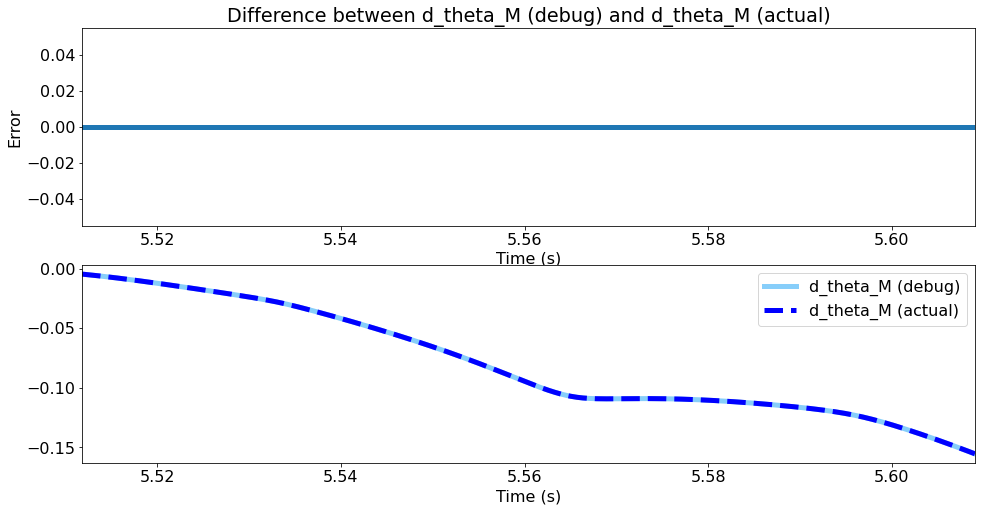

In [106]:
# plot_eq(debug_d_theta_L, "d_theta_L (debug)", d_theta_L, "d_theta_L (actual)")
# plot_vec(debug_N_hat, "N_hat (debug)", N_hat, "N_hat (actual)")
# plot_vec(debug_T_hat, "T_hat (debug)", T_hat, "T_hat (actual)")
# plot_vec(debug_p_L, "p_L (debug)", p_L, "p_L (actual)")
# plot_eq(debug_p_LN, "p_LN (debug)", p_LN, "p_LN (actual)")
# plot_eq(debug_d_N, "d_N (debug)", d_N, "d_N (actual)")
# plot_eq(debug_d_T, "d_T (debug)", d_T, "d_T (actual)")
# plot_eq(debug_d_d_N, "d_d_N (debug)", d_d_N, "d_d_N (actual)")
# plot_eq(debug_d_d_T, "d_d_T (debug)", d_d_T, "d_d_T (actual)")
# plot_eq(debug_F_GT, "F_GT (debug)", F_GT, "F_GT (actual)")
# plot_eq(debug_F_GN, "F_GN (debug)", F_GN, "F_GN (actual)")
# plot_eq(debug_F_OT, "F_OT (debug)", F_OT, "F_OT (actual)")
# plot_eq(debug_F_ON, "F_ON (debug)", F_ON, "F_ON (actual)")
# plot_eq(debug_tau_O, "tau_O (debug)", tau_O, "tau_O (actual)")
# plot_eq(debug_p_CN, "p_CN (debug)", p_CN, "p_CN (actual)")
# plot_eq(debug_p_CT, "p_CT (debug)", p_CT, "p_CT (actual)")
# plot_eq(debug_p_LN, "p_LN (debug)", p_LN, "p_LN (actual)")
# plot_eq(debug_p_LT, "p_LT (debug)", p_LT, "p_LT (actual)")
# plot_vec(debug_p_MConM, "p_MConM (debug)", p_MConM, "p_MConM (actual)")
# plot_eq(debug_theta_L, "theta_L (debug)", theta_L, "theta_L (actual)")
# plot_eq(debug_mu_S, "mu_S (debug)", mu_S, "mu_S (actual)")
# plot_eq(debug_hats_T, "hats_T (debug)", s_hat_T, "hats_T (actual)")
# plot_eq(debug_s_hat_X, "s_hat_X (debug)", s_hat_X, "s_hat_X (actual)")
# plot_vec(debug_Jdot_qdot, "Jdot_qdot (debug)", np.matmul(J_dot, d_q), "Jdot_qdot (actual)")
# plot_eq(debug_theta_M, "theta_M (debug)", theta_M, "theta_M (actual)")
plot_eq(debug_d_theta_M, "d_theta_M (debug)", d_theta_M, "d_theta_M (actual)")

# Check theta conventions

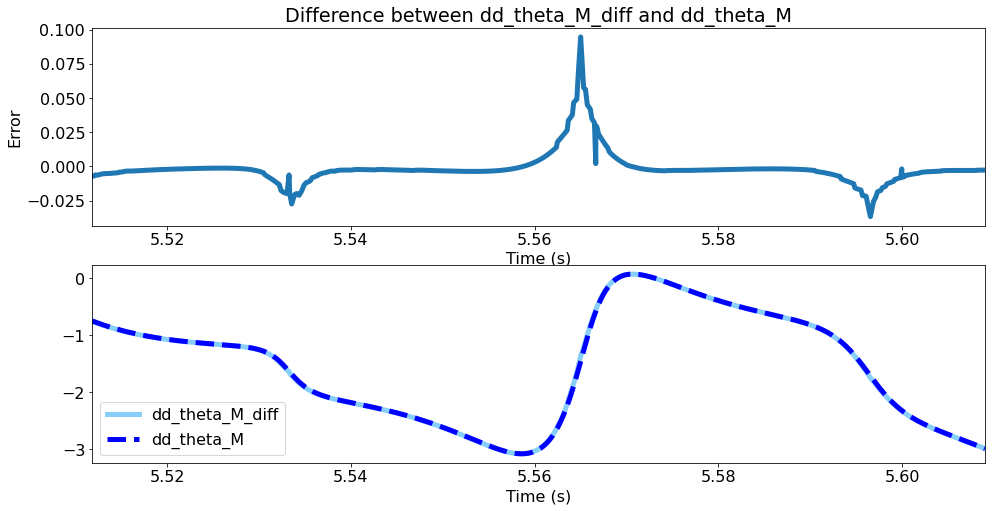

In [107]:
dd_theta_M_diff = diff_arr(d_theta_M)
plot_eq(dd_theta_M_diff, "dd_theta_M_diff", dd_theta_M, "dd_theta_M")

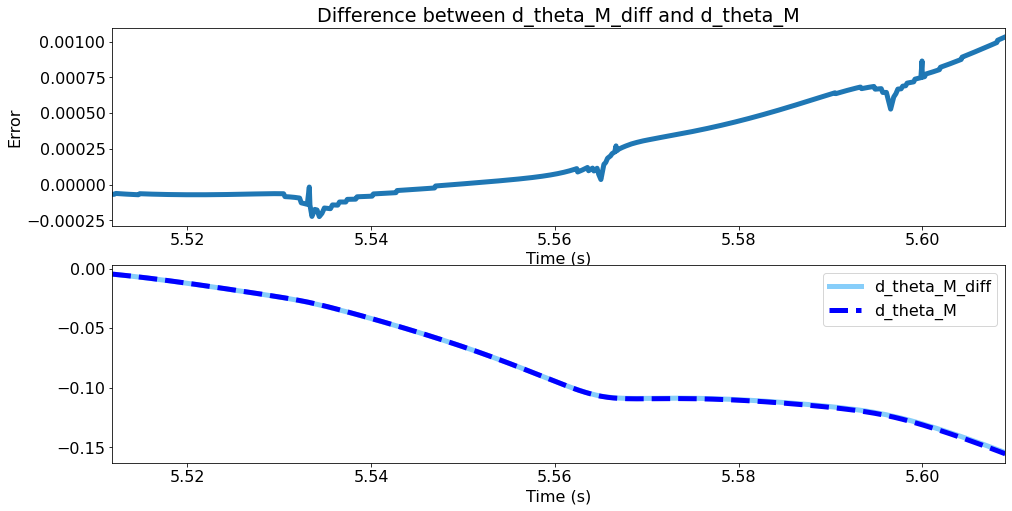

In [108]:
d_theta_M_diff = diff_arr(theta_M)
plot_eq(d_theta_M_diff, "d_theta_M_diff", d_theta_M, "d_theta_M")

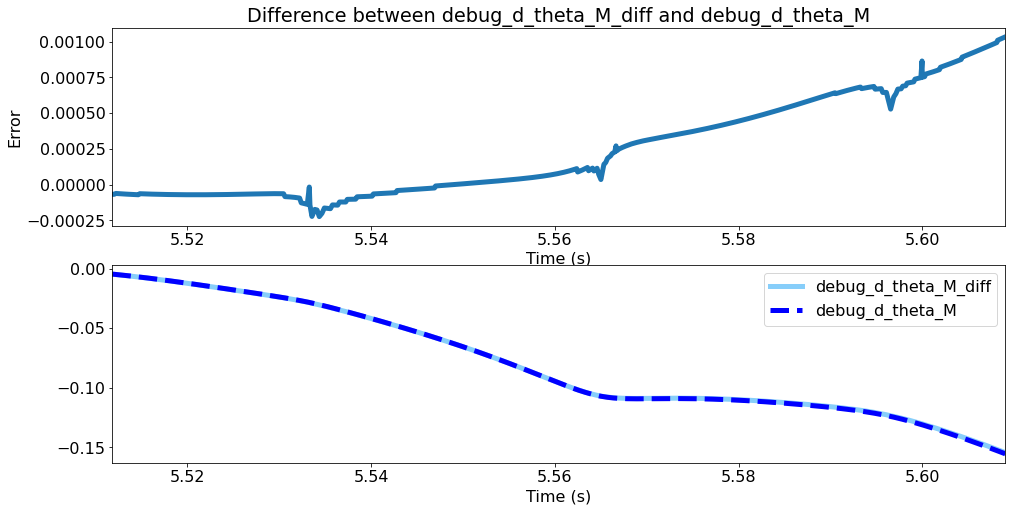

In [109]:
debug_d_theta_M_diff = diff_arr(debug_theta_M)
plot_eq(debug_d_theta_M_diff, "debug_d_theta_M_diff", debug_d_theta_M, "debug_d_theta_M")

# Plots (environmental constraints)
There are things where I expect them to be satisfied no matter what, no matter the succes my controller.

## Link (x) accel $m_La_{LX} = F_{FLX} + F_{OX}$

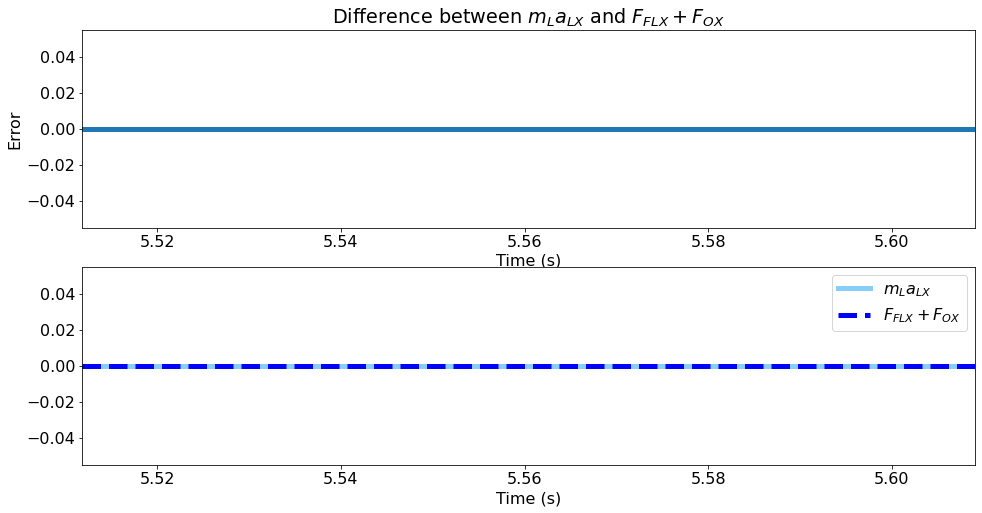

<ipython-input-99-6e1726528457>:28: RuntimeWarning: invalid value encountered in double_scalars
  max_error_pct.append(max_error/max_val)
<ipython-input-99-6e1726528457>:29: RuntimeWarning: invalid value encountered in double_scalars
  med_error_pct.append(max_error/max_val)


In [110]:
lhs_label = r'$m_La_{LX}$'
rhs_label = r'$F_{FLX} + F_{OX}$'

lhs = m_L*a_LX

rhs = F_FLX + F_OX

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Link (T) accel $m_La_{LT} = F_{FLT} + F_{GT} +F_{OT}$
*If this plot is correct:*
The free body diagram is correct in thet $\hat T$ direction on the link.

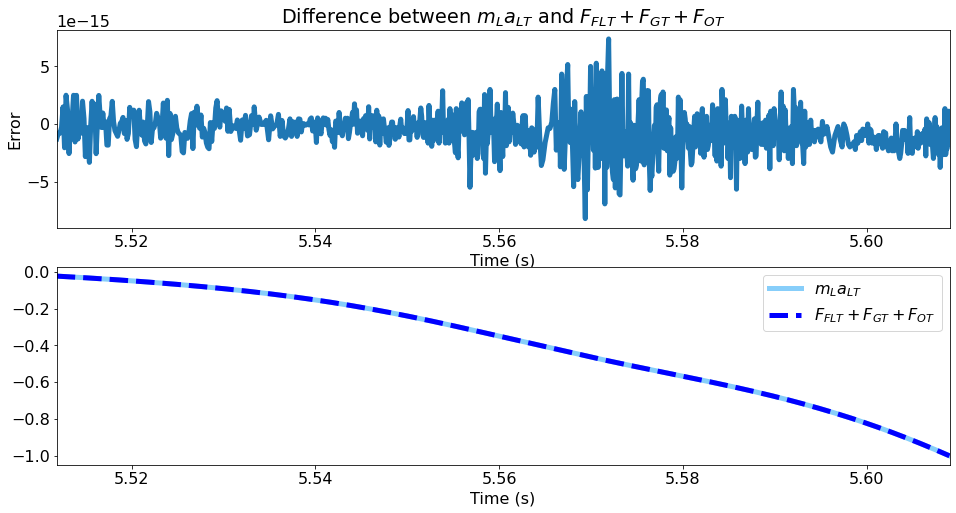

In [111]:
lhs_label = r'$m_La_{LT}$'
rhs_label = r'$F_{FLT} + F_{GT} +F_{OT}$'

lhs = m_L*a_LT
lhs /= np.max(np.abs(lhs[idx_start:idx_end]))

rhs = F_GT+F_OT+F_FLT
rhs /= np.max(np.abs(rhs[idx_start:idx_end]))

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Link (N) accel $m_La_{LN} = F_{NL} + F_{GN} +F_{ON}$
*If this plot is correct:*
The free body diagram is correct in thet $\hat N$ direction on the link.

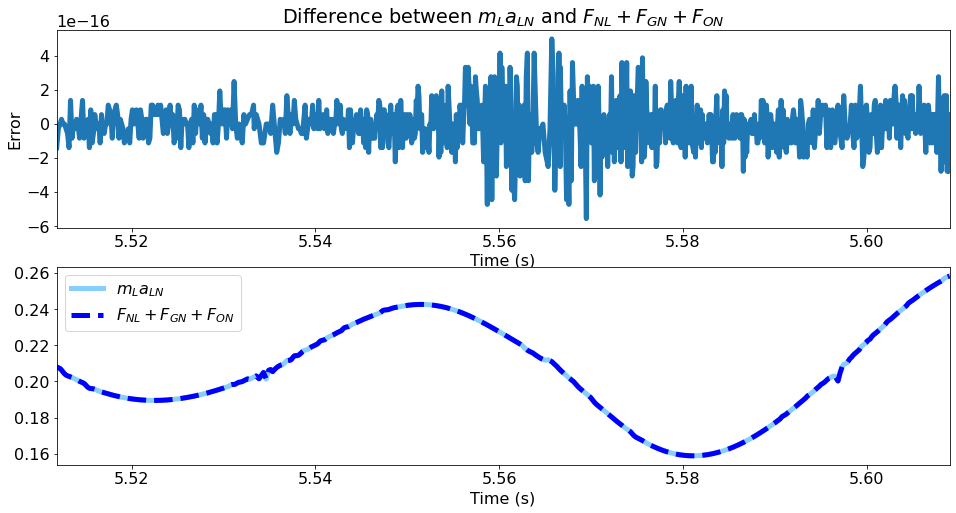

In [112]:
lhs_label = r'$m_La_{LN}$'
rhs_label = r'$F_{NL} + F_{GN} +F_{ON}$'

lhs = m_L*a_LN

rhs = F_NL + F_GN + F_ON

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Link (x) angle accel $I_L\ddot\theta_L = -\frac{w_L}{2}F_{ON} - (p_{CN}-p_{LN})F_{FL} + (p_{CT}-p_{LT})F_{NL}+\tau_O$
*If this plot is correct:* The moment balance on the link is correct.

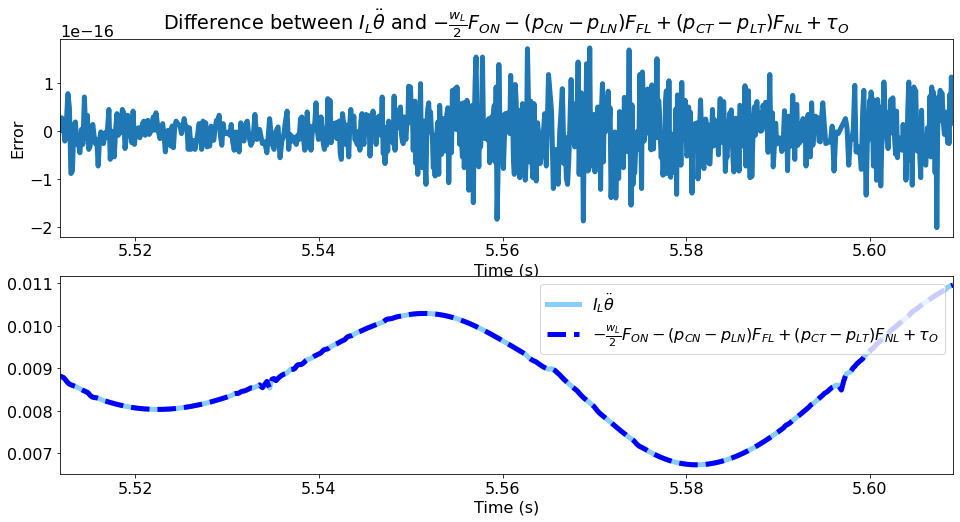

In [113]:
lhs_label = r'$I_L\ddot\theta$'
rhs_label = r'$-\frac{w_L}{2}F_{ON} - (p_{CN}-p_{LN})F_{FL} + (p_{CT}-p_{LT})F_{NL}+\tau_O$'

lhs = I_L*dd_theta_L

N_lever_arm = np.nan_to_num(p_CN-p_LN)
T_lever_arm = np.nan_to_num(p_CT-p_LT)
rhs = (-w_L/2)*F_ON - N_lever_arm * F_FLT + T_lever_arm*F_NL + tau_O

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## 3rd law normal forces $F_{NL} = -F_{NM}$
*If this plot is correct:* Newton's 3rd law is correction applied to the normal forces.

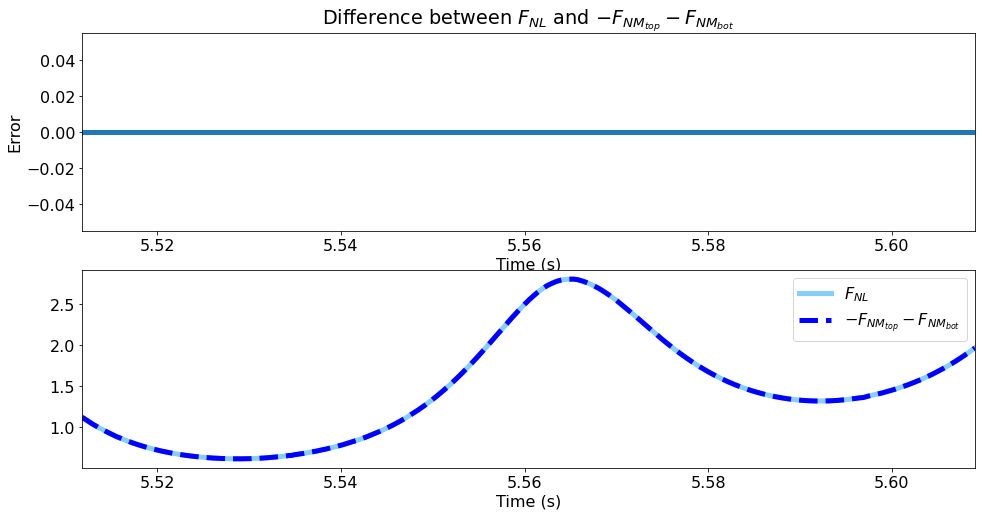

In [114]:
lhs_label = r'$F_{NL}$'
rhs_label = r'$-F_{NM_{top}}-F_{NM_{bot}}$'

lhs = F_NL

rhs = -F_NM

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## 3rd law friction forces $F_{FLT} = -F_{FMT}$
*If this plot is correct:* Newton's 3rd law is correction applied to the friction forces in the tangent direction.

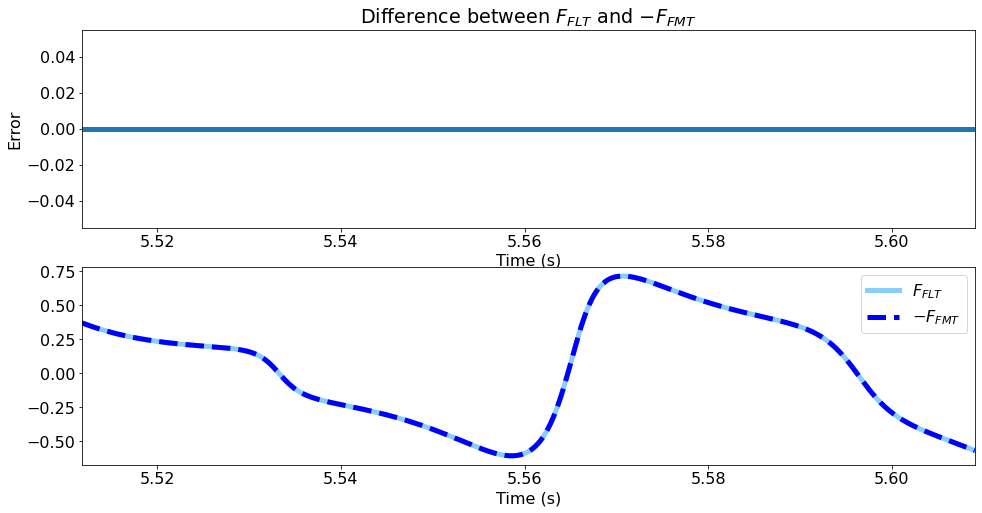

In [115]:
lhs_label = r'$F_{FLT}$'
rhs_label = r'$-F_{FMT}$'

lhs = F_FLT

rhs = -F_FMT

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## d vec tangential derivative $-\ddot\theta_L h_L/2 - \ddot\theta_L r + \dot\theta_L^2 w_L/2 - a_{LT} + a_{MT} = -\ddot\theta_L {d}_N + \ddot{d}_T - \dot\theta_L^2 {d}_T - 2\dot\theta_L \dot{d}_N$
*If this plot is correct:* The derivatives for  $\vec d$  are correct.

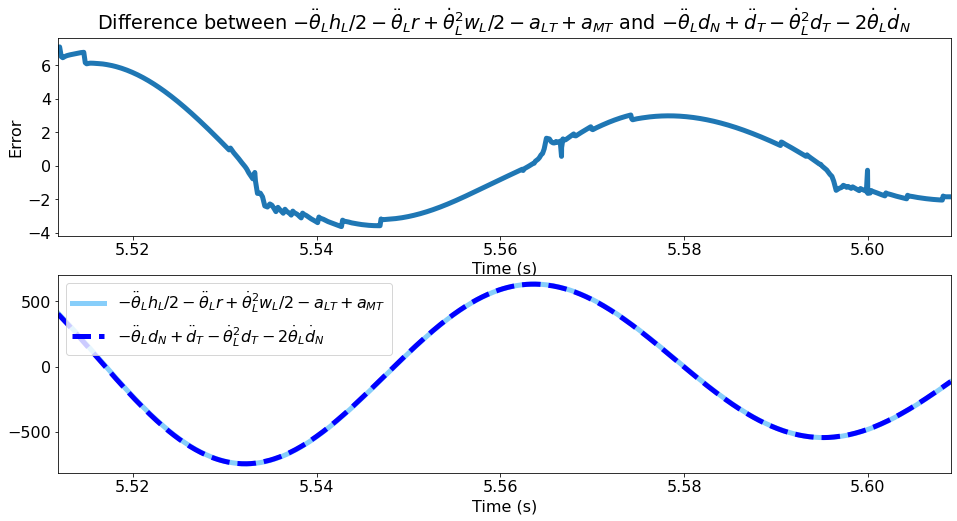

In [116]:
lhs = -dd_theta_L*(h_L/2+r) + d_theta_L**2*w_L/2 - a_LT + a_MT
lhs_label = r"$-\ddot\theta_L h_L/2 - \ddot\theta_L r + \dot\theta_L^2 w_L/2 - a_{LT} + a_{MT}$"

rhs = -dd_theta_L*d_N + dd_d_T - d_theta_L**2*d_T - 2*d_theta_L*d_d_N
rhs_label = r"$-\ddot\theta_L {d}_N + \ddot{d}_T - \dot\theta_L^2 {d}_T - 2\dot\theta_L \dot{d}_N$"

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label, newline_in_label=True)

## d vec normal derivative $- \frac{w_{L}}{2}\ddot\theta_{L} - \frac{h_{L}}{2}\dot\theta_{L}^{2} - \dot\theta_{L}^{2} r - a_{LN} + a_{MN} = \ddot\theta_{L} d_{T} + \ddot{d}_N - \dot\theta_{L}^{2} d_{N} + 2 \dot\theta_{L} \dot{d}_T$
*If this plot is correct:* The derivatives for  $\vec d$  are correct.

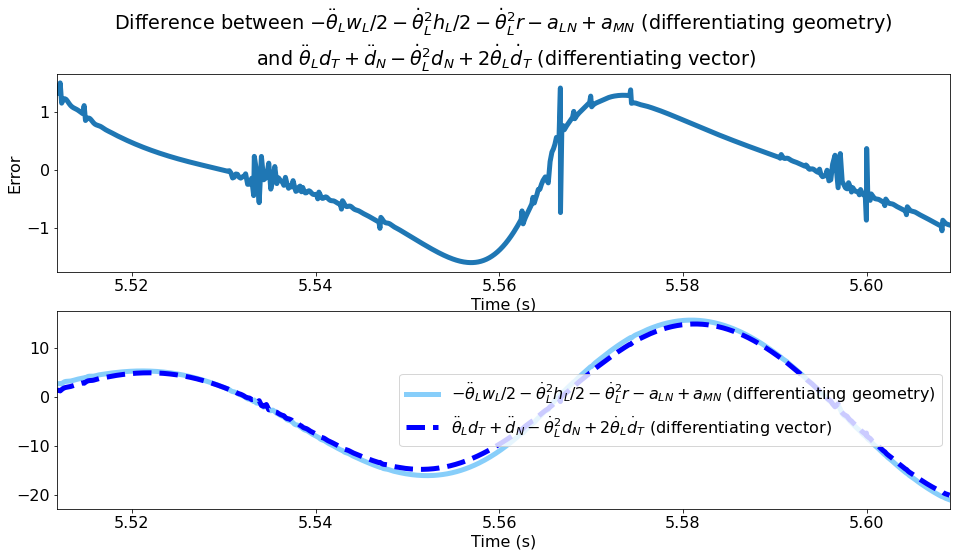

In [117]:
lhs = -dd_theta_L*w_L/2 - d_theta_L**2*h_L/2 - d_theta_L**2*r - a_LN + a_MN
lhs_label = r"$-\ddot\theta_L w_L/2 - \dot\theta_L^2 h_L/2 - \dot\theta_L^2 r - a_{LN} + a_{MN}$ (differentiating geometry)"

rhs = dd_theta_L*d_T + dd_d_N - d_theta_L**2*d_N + 2*d_theta_L*d_d_T
rhs_label = r"$\ddot\theta_L {d}_T + \ddot{d}_N - \dot\theta_L^2 {d}_N + 2 \dot\theta_L \dot{d}_T$ (differentiating vector)"

plot_eq(lhs, lhs_label, rhs, rhs_label, newline_in_title=True)

lhs_label = r"$-\ddot\theta_L w_L/2 - \dot\theta_L^2 h_L/2 - \dot\theta_L^2 r - a_{LN} + a_{MN}$"
rhs_label = r"$\ddot\theta_L {d}_T + \ddot{d}_N - \dot\theta_L^2 {d}_N + 2 \dot\theta_L \dot{d}_T$"
update_error(lhs, lhs_label, rhs, rhs_label, newline_in_label=True)
plt.show()

## No penetration $\ddot d_N = 0$
*If this plot is correct:* There is effectively no penetration between the rigid bodies.

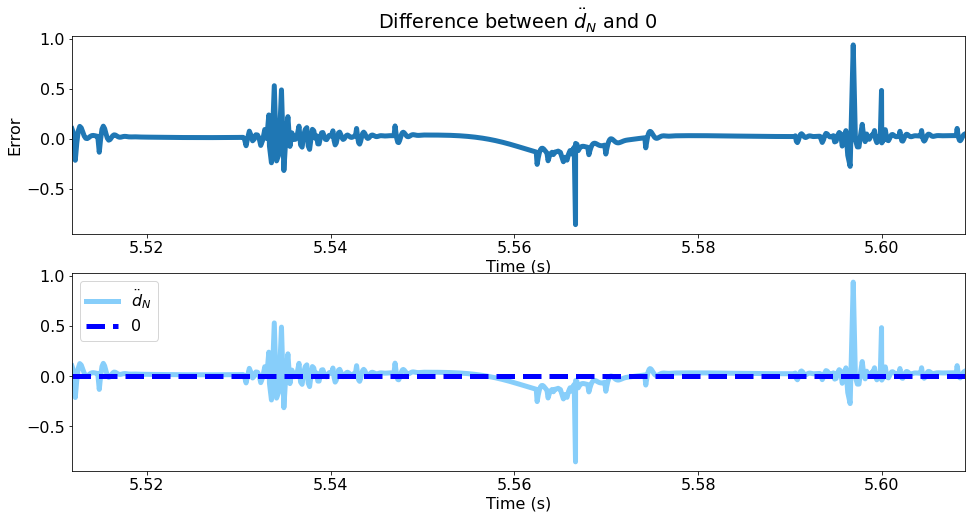

In [118]:
lhs_label = r'$\ddot{d}_N$'
rhs_label = r'0'

lhs = dd_d_N

rhs = 0

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Link (T) friction equation $F_{FLT}=\mu\mu_SF_{NL}\hat s_T$

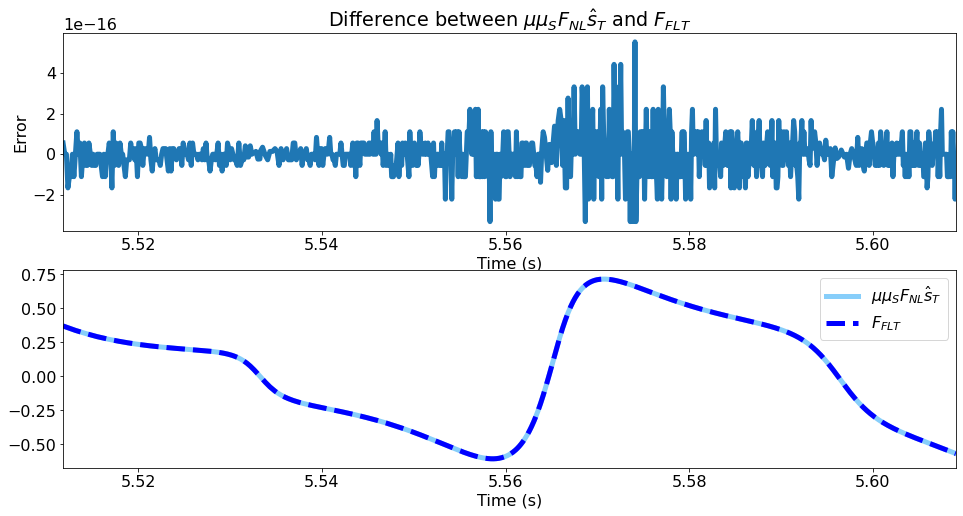

In [119]:
lhs_label = r'$\mu\mu_SF_{NL}\hat s_T$'
rhs_label = r'$F_{FLT}$'

lhs = np.nan_to_num(mu_S*F_NL*mu*s_hat_T)
rhs = F_FLT

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Link (x) friction equation $F_{FLX}=\mu\mu_SF_{NL}\hat s_X$

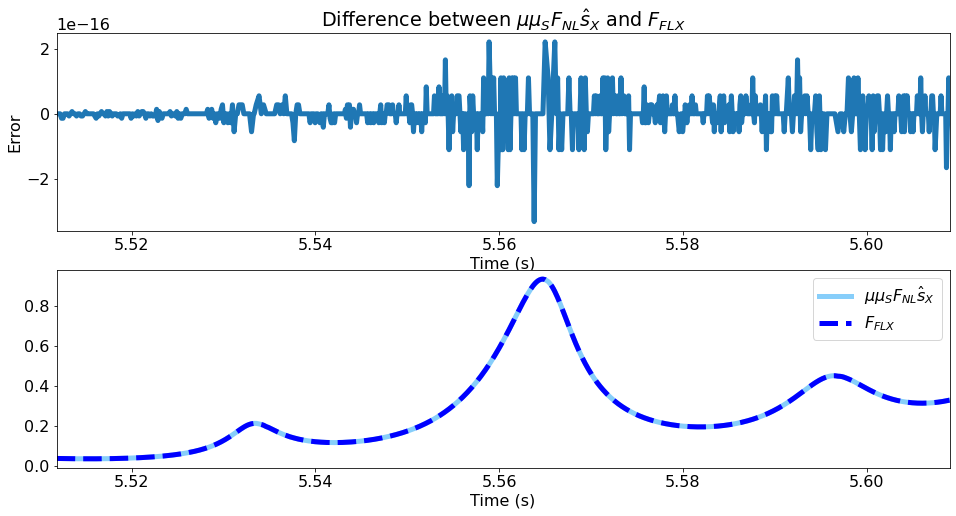

In [120]:
lhs_label = r'$\mu\mu_SF_{NL}\hat s_X$'
rhs_label = r'$F_{FLX}$'

lhs = np.nan_to_num(mu_S*F_NM*mu*s_hat_X)
rhs = F_FMX

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Jacobian and (x) accel $a_{MX}=\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_3$

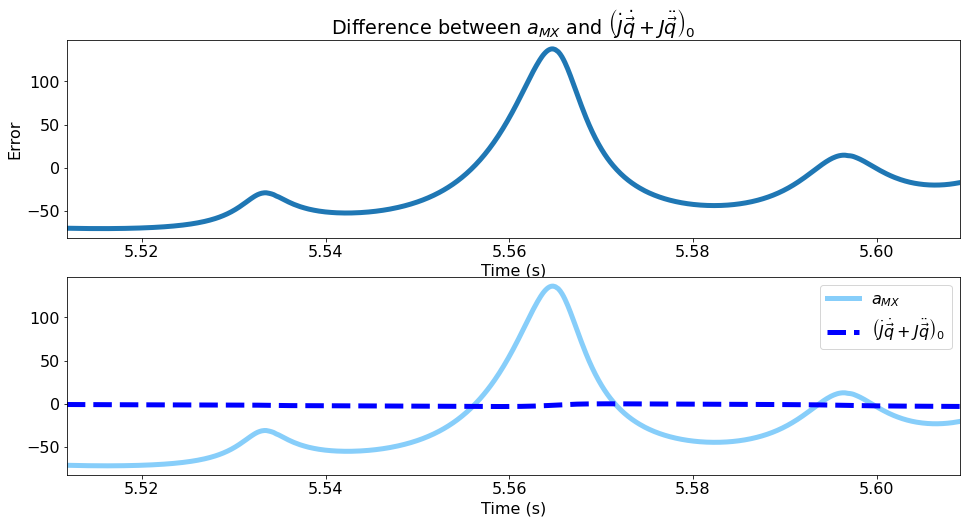

In [121]:
lhs_label = r'$a_{MX}$'
rhs_label = r'$\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_0$'

lhs = a_MX
rhs = (np.matmul(J_dot, d_q) + np.matmul(J, dd_q))[:,0].flatten()

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Jacobian and (y) accel $a_{MY}=\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_3$

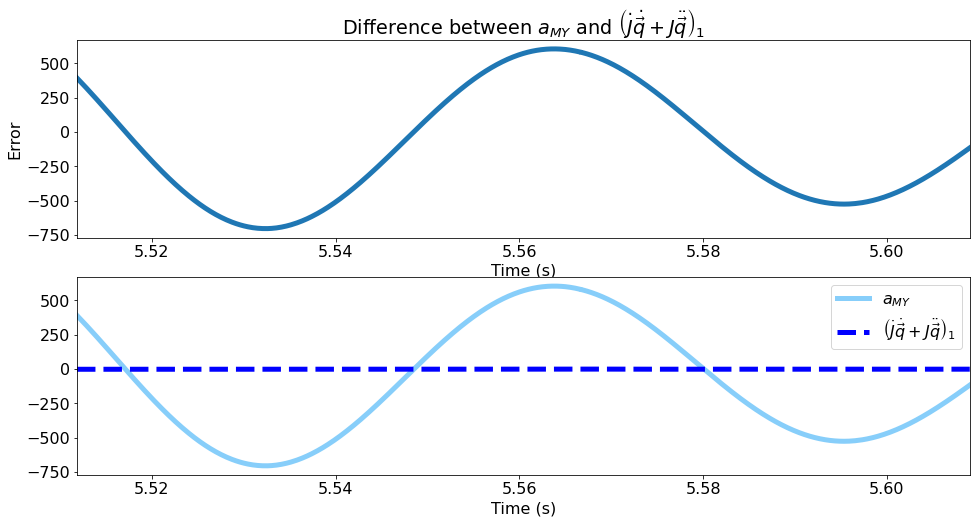

In [122]:
lhs_label = r'$a_{MY}$'
rhs_label = r'$\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_1$'

lhs = a_MY
rhs = (np.matmul(J_dot, d_q) + np.matmul(J, dd_q))[:,1].flatten()

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Jacobian and (z) accel $a_{MZ}=\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_3$

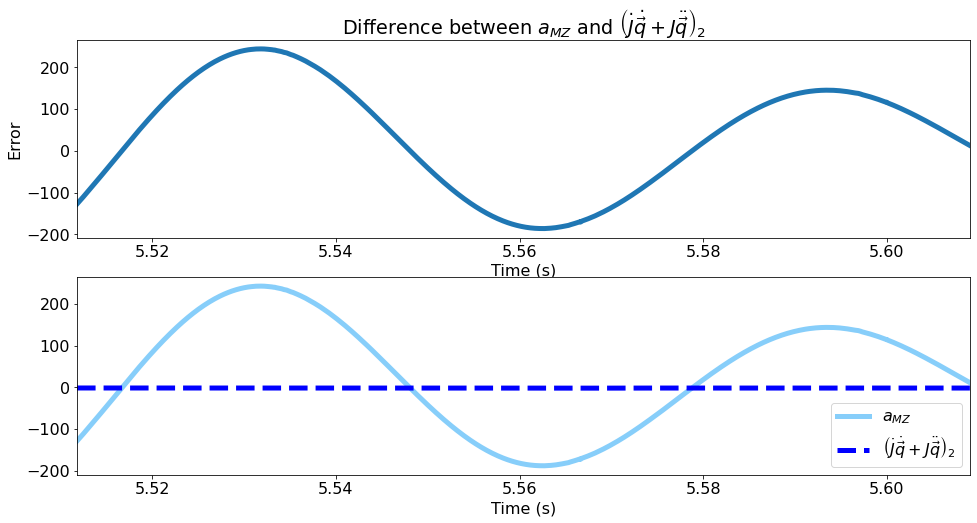

In [123]:
lhs_label = r'$a_{MZ}$'
rhs_label = r'$\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_2$'

lhs = a_MZ
rhs = (np.matmul(J_dot, d_q) + np.matmul(J, dd_q))[:,2].flatten()

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Jacobian and (x) ang accel $\alpha_{MX}=\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_4$

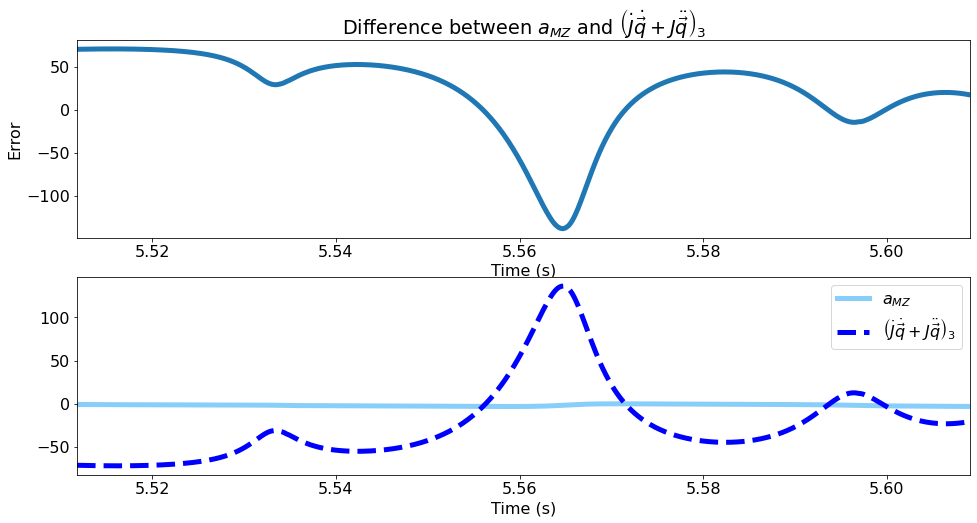

In [124]:
lhs_label = r'$a_{MZ}$'
rhs_label = r'$\left(\dot{J} \dot{\vec{q}} + J\ddot{\vec{q}}\right)_3$'

lhs = alpha_MX
rhs = (np.matmul(J_dot, d_q) + np.matmul(J, dd_q))[:,3].flatten()

plot_eq(lhs, lhs_label, rhs, rhs_label)
update_error(lhs, lhs_label, rhs, rhs_label)

## Manipulator equation $M \ddot q + C \dot q = \tau_g + \vec \tau_{\text{contact}} + \vec \tau_{\text{control}}$

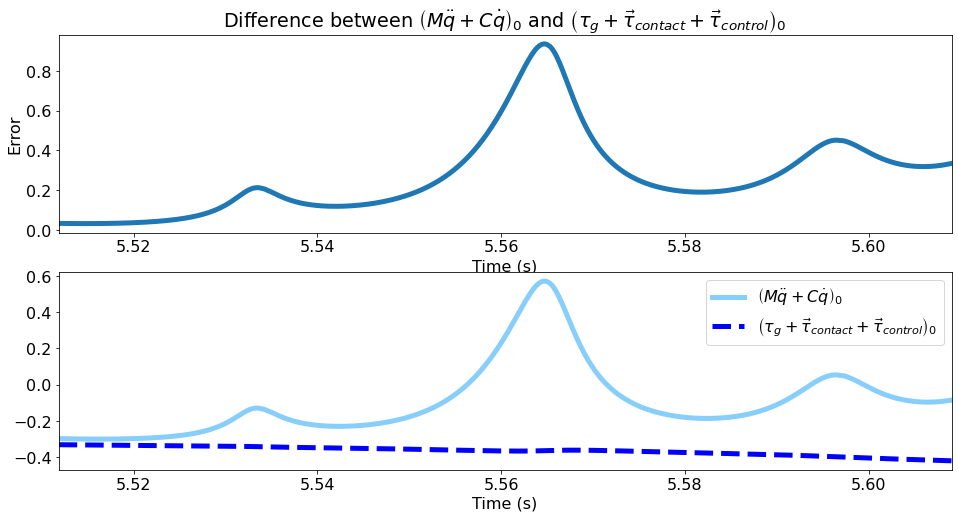

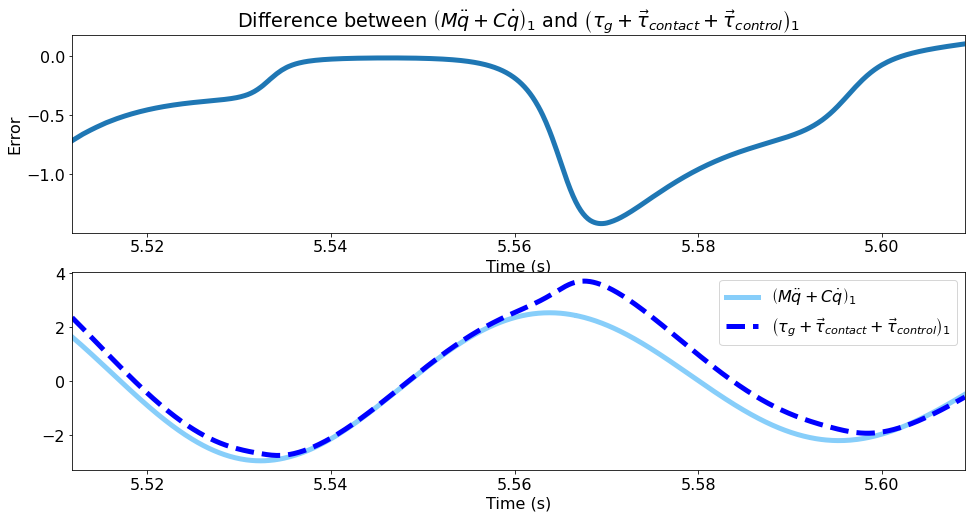

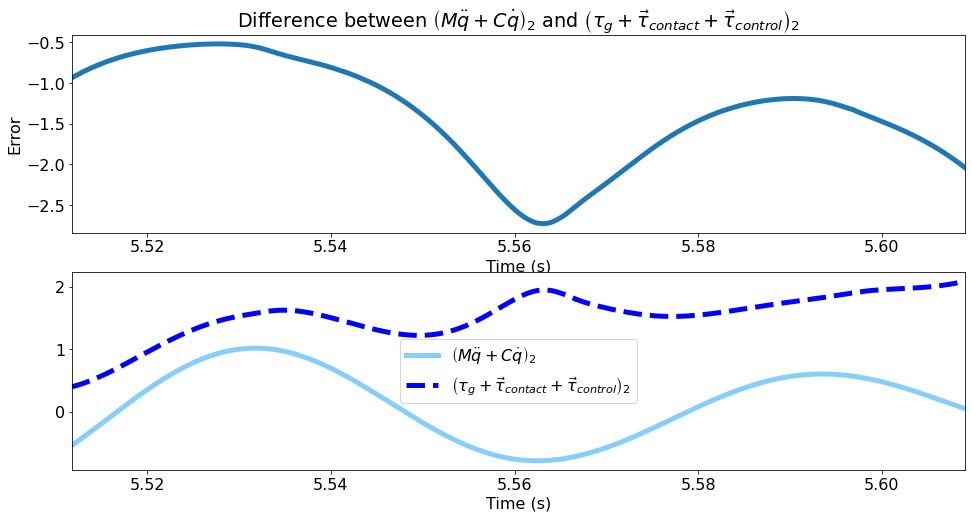

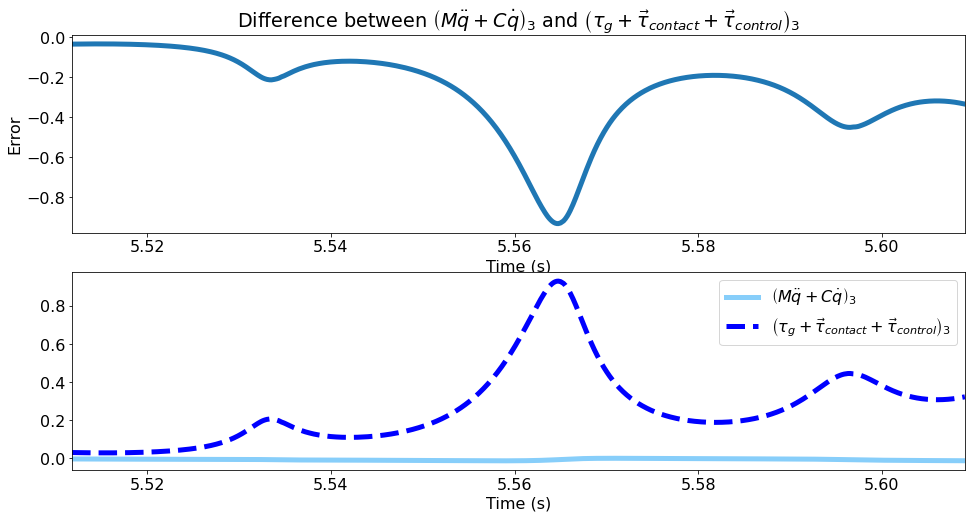

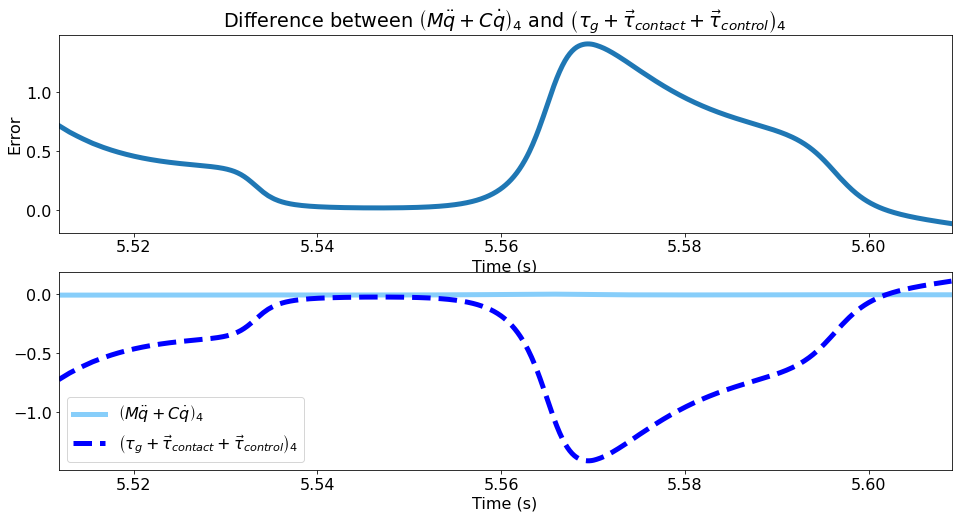

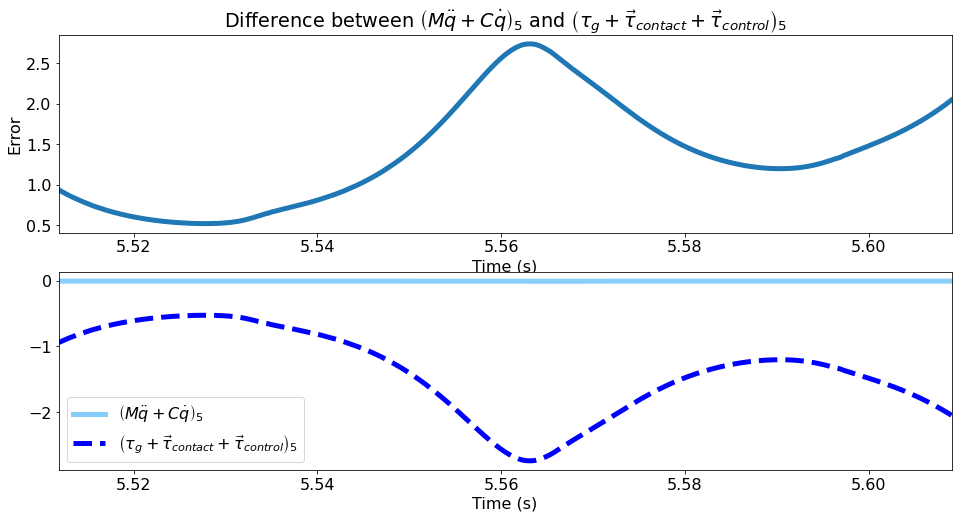

In [125]:
lhs_ = np.matmul(M, dd_q) + Cv
lhs_label_ = r"M \ddot q + C \dot q"
rhs_ = tau_g + tau_contact + tau_out
rhs_label_ = r"\tau_g + \vec \tau_{contact} + \vec \tau_{control}"
labels = [str(i) for i in range(nq)]

for i, label in enumerate(labels):
    lhs = lhs_[:,i,:]
    lhs_label = r"$\left(" + lhs_label_ + r"\right)_" + label + "$"

    rhs = rhs_[:,i,:]
    rhs_label = r"$\left(" + rhs_label_ + r"\right)_" + label + "$"

    plot_eq(lhs, lhs_label, rhs, rhs_label)
    plt.show()

# Plot errors
How accurate is my modeling?

## Absolute error

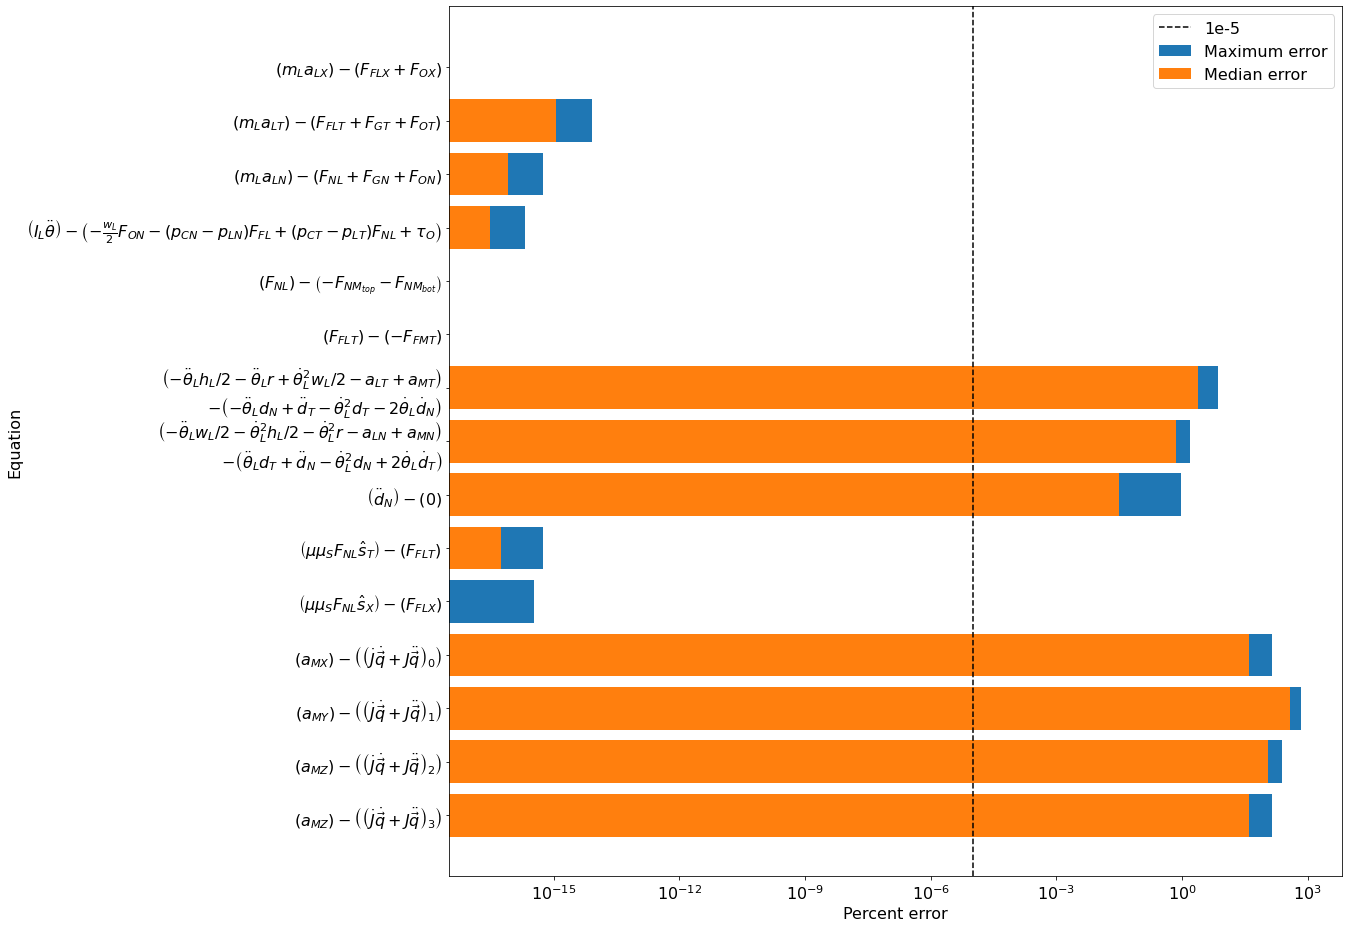

In [156]:
plt.figure(figsize=(16,16))
plt.barh(error_labels[::-1], np.array(max_errors[::-1]), label="Maximum error")
plt.barh(error_labels[::-1], np.array(med_errors[::-1]), label="Median error")
plt.axvline(1e-5, color='k', linestyle='--', label="1e-5")
plt.xscale("log")
plt.xlabel("Log(error)")
plt.xlabel("Percent error")
plt.ylabel("Equation")
plt.legend()
# plt.xlim(0, 100)
plt.show()

## Percent error

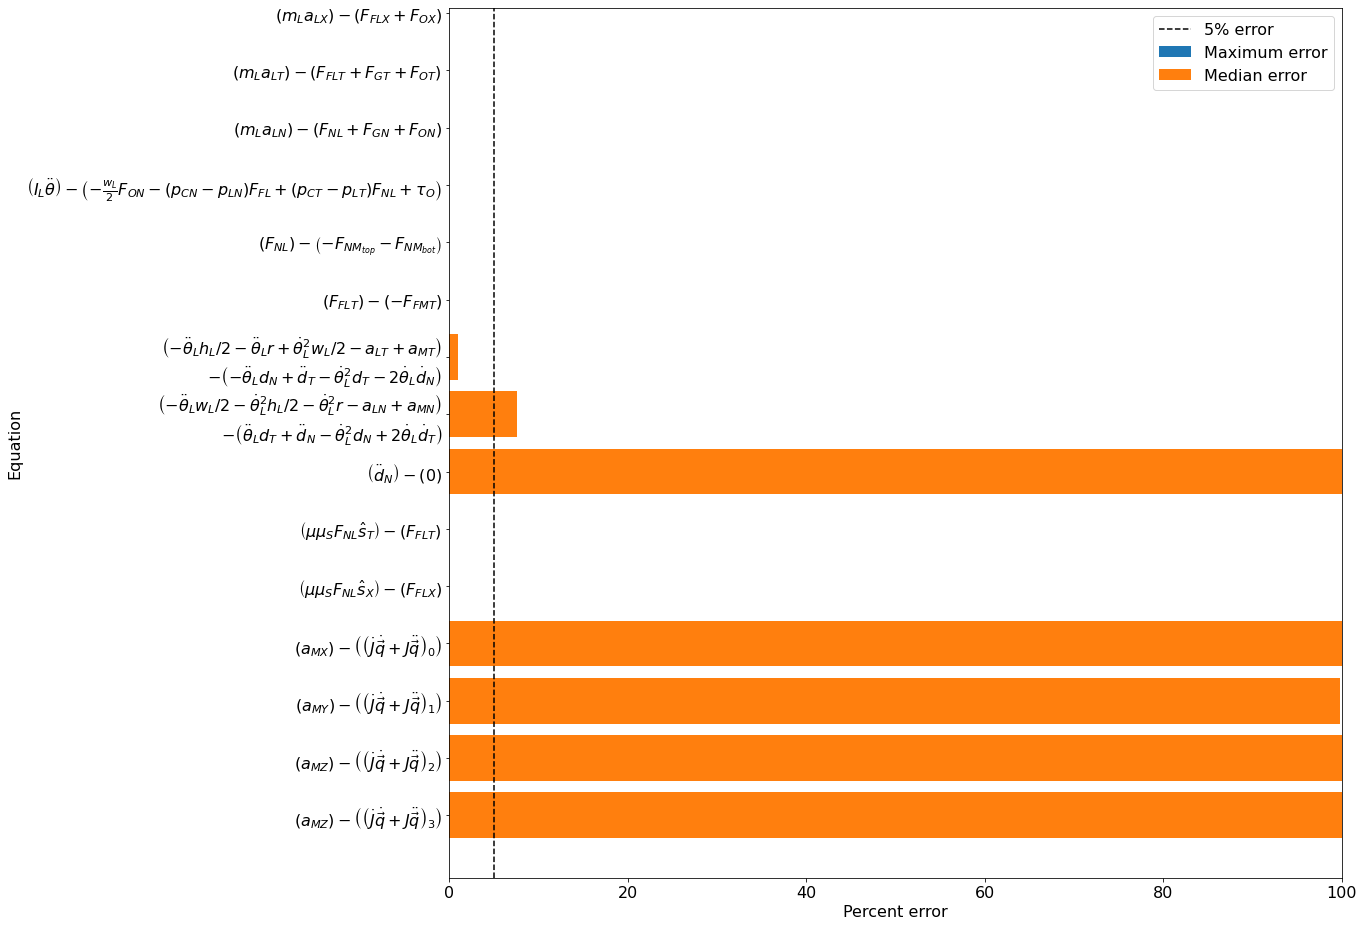

In [126]:
plt.figure(figsize=(16,16))
plt.barh(error_labels[::-1], np.array(max_error_pct[::-1])*100, label="Maximum error")
plt.barh(error_labels[::-1], np.array(med_error_pct[::-1])*100, label="Median error")
plt.axvline(5, color='k', linestyle='--', label="5% error")
# plt.xscale("log")
# plt.xlabel("Log(error)")
plt.xlabel("Percent error")
plt.ylabel("Equation")
plt.legend()
plt.xlim(0, 100)
plt.show()

# Environmental constraints (two link specific)

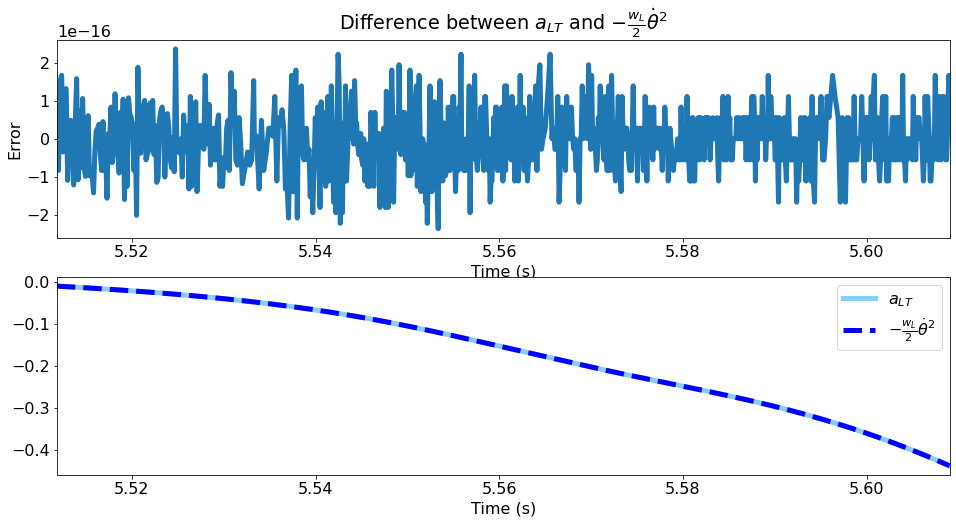

In [127]:
lhs = a_LT
lhs_label = r"$a_{LT}$"
rhs = (-w_L/2)*d_theta_L**2
rhs_label = r"$-\frac{w_L}{2}\dot\theta^2$"
plot_eq(lhs, lhs_label, rhs, rhs_label)

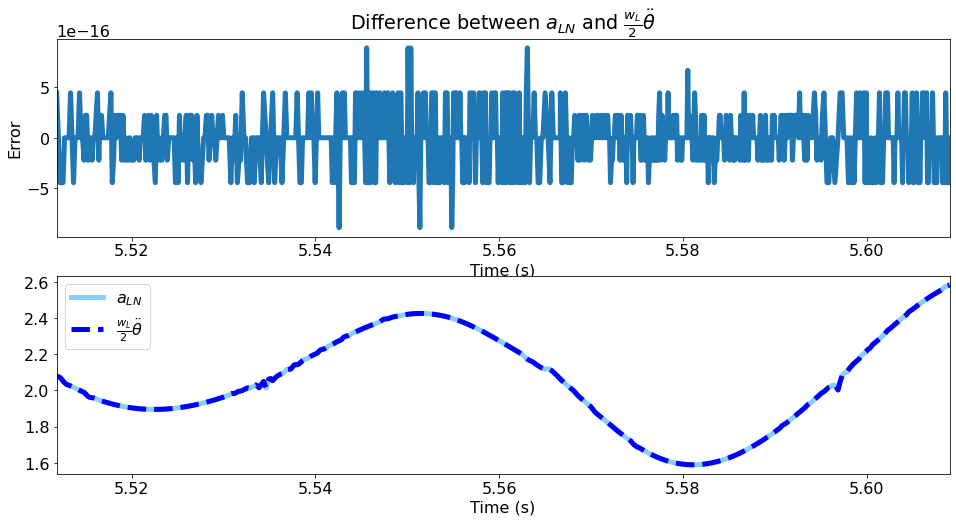

In [128]:
lhs = a_LN
lhs_label = r"$a_{LN}$"
rhs = (w_L/2)*dd_theta_L
rhs_label = r"$\frac{w_L}{2}\ddot\theta$"
plot_eq(lhs, lhs_label, rhs, rhs_label)

# Other plots
These aren't necessarily constraints in the program, but I do want to check them.

## Friction
### Norm

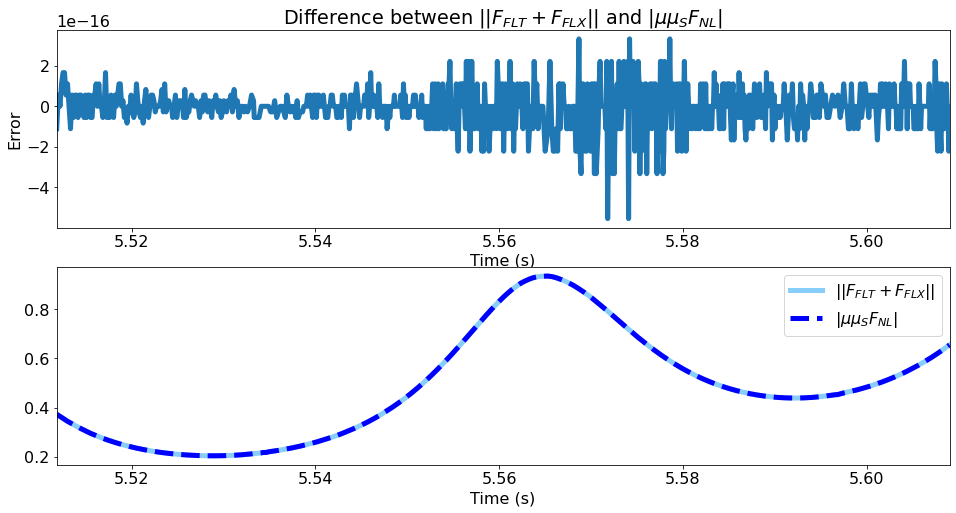

In [129]:
lhs = np.linalg.norm(np.expand_dims(F_FLX, [1,2])*x_hat + np.expand_dims(F_FLT, [1,2])*T_hat, axis=1)
lhs_label = r"$||F_{FLT} + F_{FLX}||$"

rhs = np.abs(np.expand_dims(mu*mu_S*F_NL, 1))
rhs_label = "$|\mu\mu_{S}F_{NL}|$"

plot_eq(lhs, lhs_label, rhs, rhs_label)
plt.show()

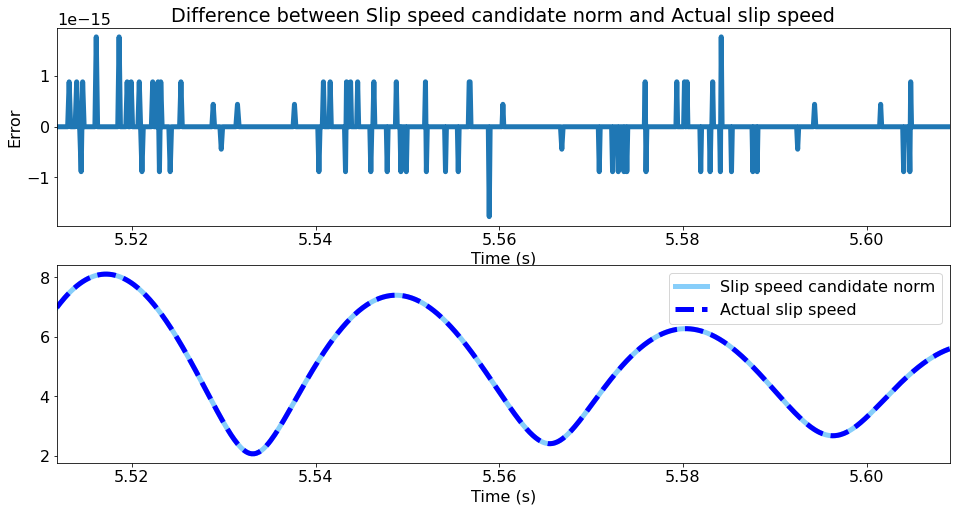

In [130]:
lhs = s_S
lhs_label = r"Slip speed candidate norm"

rhs = slip_speed
rhs_label = "Actual slip speed"

plot_eq(lhs, lhs_label, rhs, rhs_label)
plt.show()

## Direction

In [131]:
F_hat = np.expand_dims(F_FLT, [1,2])*T_hat + np.expand_dims(F_FLX, [1,2])*x_hat
F_hat = F_hat/np.expand_dims(np.linalg.norm(F_hat, axis=1), 2)

<ipython-input-131-18d778e52a19>:2: RuntimeWarning: invalid value encountered in true_divide
  F_hat = F_hat/np.expand_dims(np.linalg.norm(F_hat, axis=1), 2)


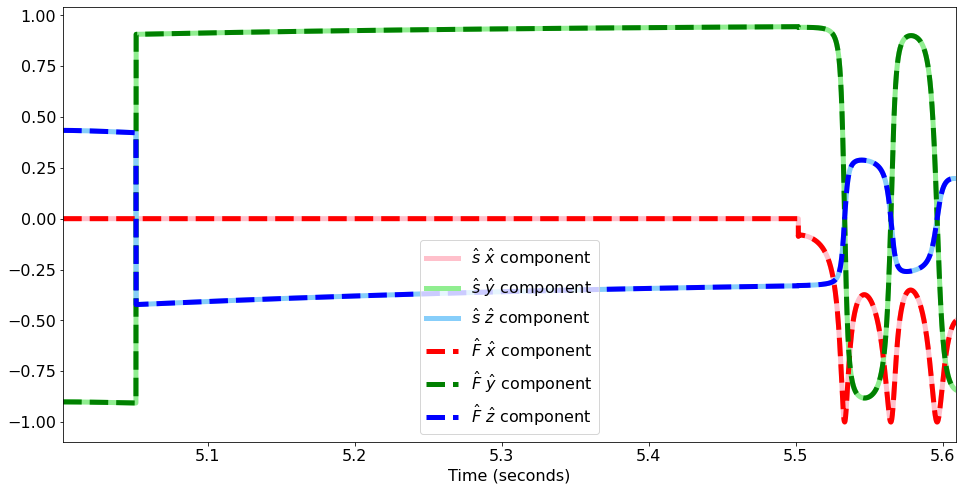

In [132]:
sig1 = s_hat
sig1_label = r"$\hat s$"

sig2 = F_hat
sig2_label = r"$\hat F$"
plot_vec(sig1, sig1_label, sig2, sig2_label, start_time=t_start_of_last_contact)

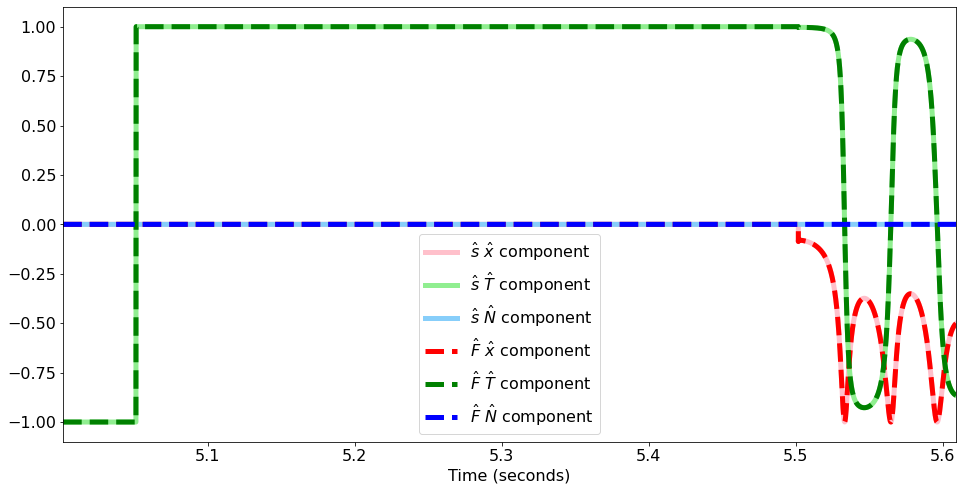

In [133]:
sig1 = s_hat
sig1_label = r"$\hat s$"

sig2 = F_hat
sig2_label = r"$\hat F$"
plot_vec_XTN(sig1, sig1_label, sig2, sig2_label, start_time=t_start_of_last_contact)

## Actual values

In [134]:
F_mag = mu_S*F_NL*mu

In [135]:
F_F_est = s_hat*np.expand_dims(np.vstack((F_mag,F_mag,F_mag)).T, 2)

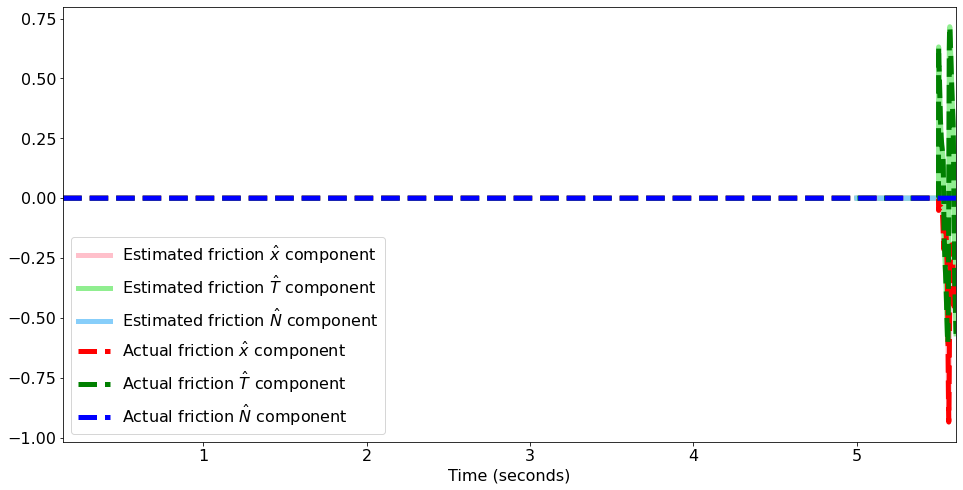

In [136]:
sig1 = F_F_est
sig1_label = r"Estimated friction"

sig2 = F_contact_L - N_hat_proj_mat@F_contact_L
sig2_label = r"Actual friction"
plot_vec_XTN(sig1, sig1_label, sig2, sig2_label, start_time=t_start_of_last_contact)

## Plots (control targets)
These will only be satisfied if the controller is successful.

### $\ddot{d}_N = \ddot{d}_{Nd}$

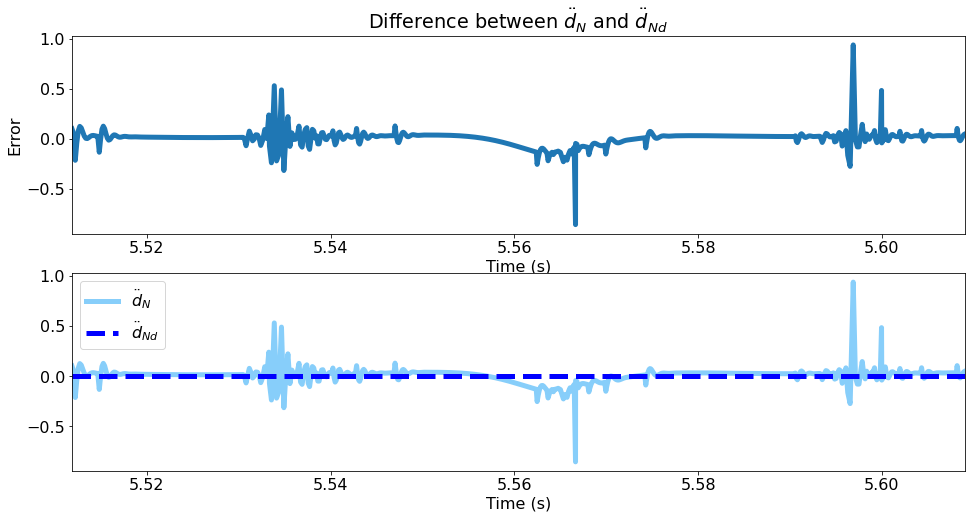

In [137]:
lhs_label = r'$\ddot{d}_N$'
rhs_label = r'$\ddot{d}_{Nd}$'

lhs = dd_d_N

rhs = 0

plot_eq(lhs, lhs_label, rhs, rhs_label)

### $a_{LN} = a_{LNd}$

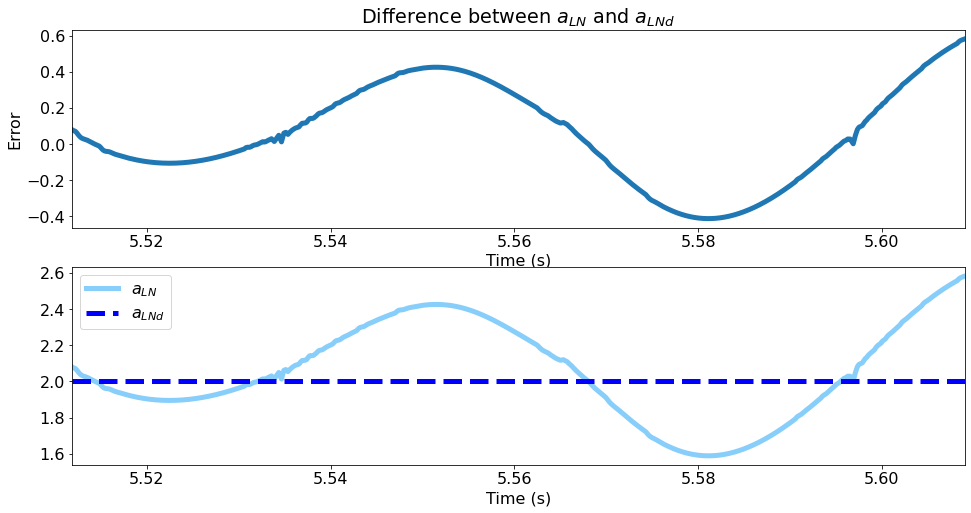

In [138]:
lhs_label = r'$a_{LN}$'
rhs_label = r'$a_{LNd}$'

lhs = a_LN

rhs = fold_ctrl.a_LNd

plot_eq(lhs, lhs_label, rhs, rhs_label)

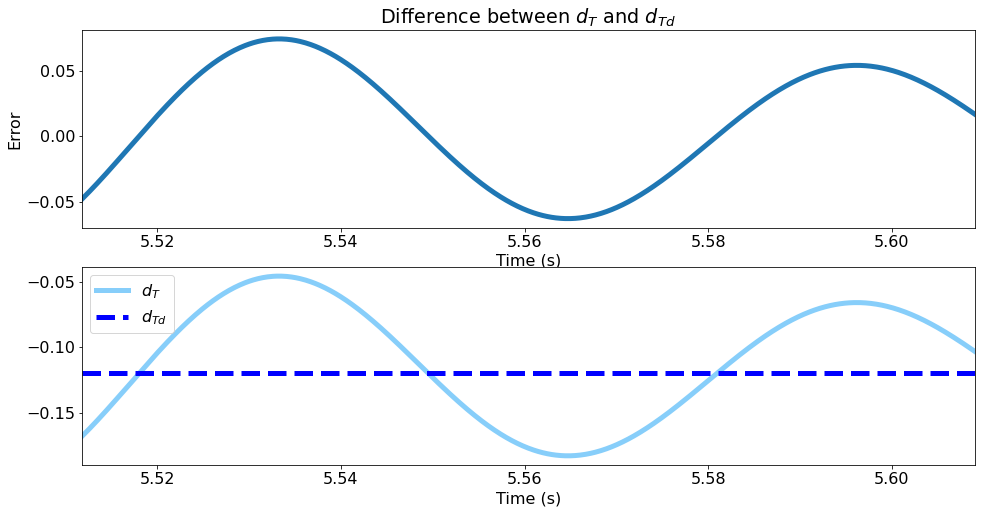

In [139]:
plot_eq(d_T, "$d_T$", fold_ctrl.d_Td, "$d_{Td}$")

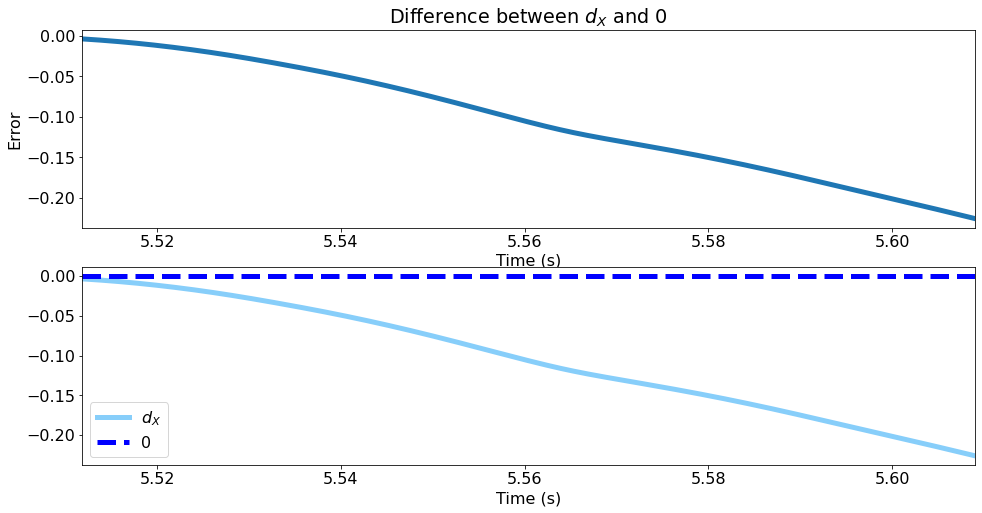

In [140]:
plot_eq(d_X, "$d_X$", 0, "0")

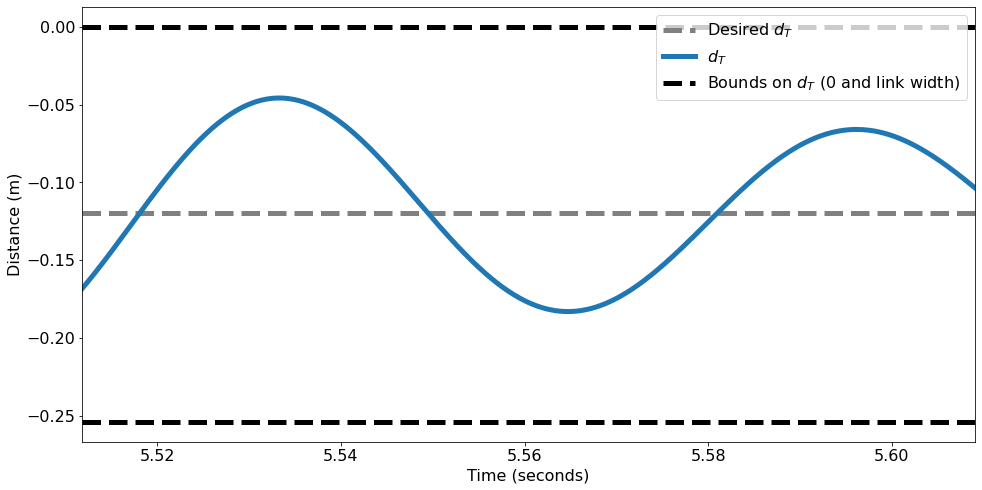

In [141]:
lw=5
plt.figure(figsize=(16, 8))
plt.axhline(fold_ctrl.d_Td, linestyle='--', color='gray', linewidth=lw, label="Desired $d_T$")
plt.plot(l_times, d_T, label='$d_T$', linewidth=lw)
plt.axhline(-(0), label='Bounds on $d_T$ (0 and link width)', linestyle='--', color='k', linewidth=lw)
plt.axhline(-(paper.link_width), linestyle='--', color='k', linewidth=lw)
plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("Distance (m)")
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlim(t_start, t_end)
plt.show()

# Pre-contact plots

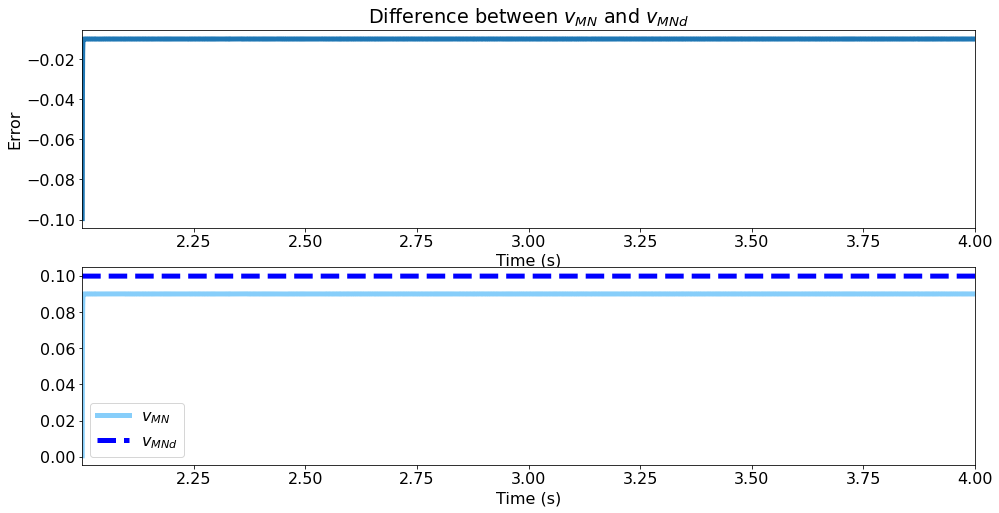

In [142]:
plot_eq(v_MN, r"$v_{MN}$", fold_ctrl.pre_contact_v_MNd, r"$v_{MNd}$", t_start=2, t_end=4)

# Parameter estimation plots
If we are using adaptive control, how well do we learn the parameters?

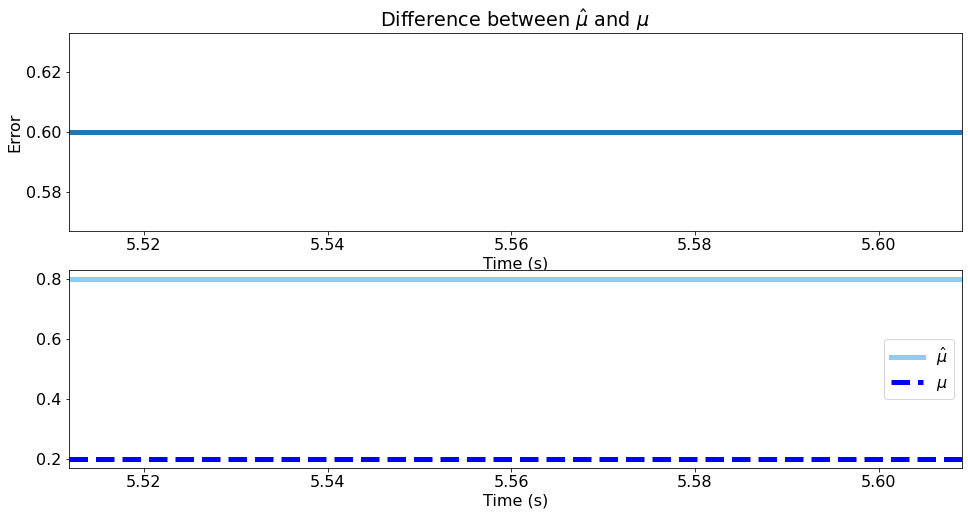

In [143]:
plot_eq(mu_hats, "$\hat\mu$", constants.FRICTION, r"$\mu$")

# Other useful plots

## Friction plots

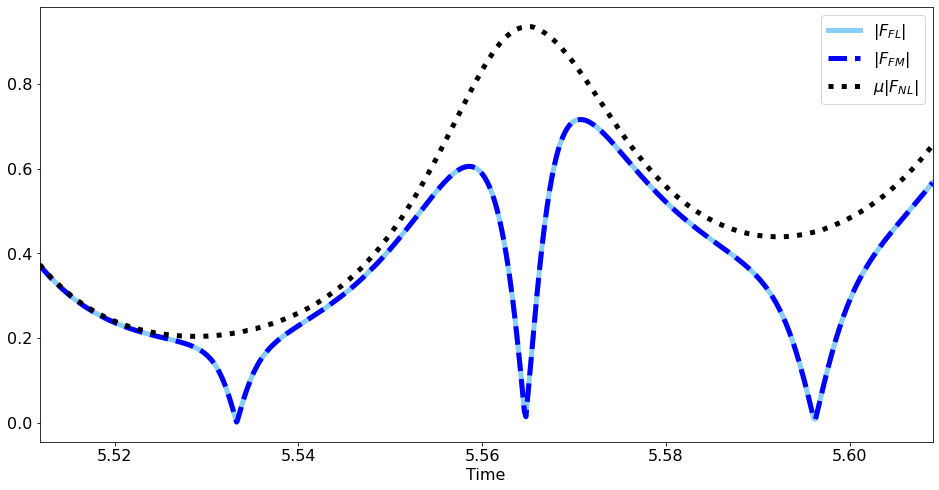

In [153]:
lw=5
plt.figure(figsize=(16,8))
plt.plot(l_times[idx_start:idx_end],
         abs(F_FLT[idx_start:idx_end]), label=r"$\left|F_{FL}\right|$", linewidth=lw, color='lightskyblue', zorder=0)
plt.plot(l_times[idx_start:idx_end],
         abs(F_FMT[idx_start:idx_end]), label=r"$\left|F_{FM}\right|$", linewidth=lw, color='b', linestyle='--', zorder=1)
plt.plot(l_times[idx_start:idx_end],
         abs(F_NL[idx_start:idx_end])*mu, label=r"$\mu\left|F_{NL}\right|$", linewidth=lw, color='k', linestyle=':')

plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.xlabel("Time")
plt.show()

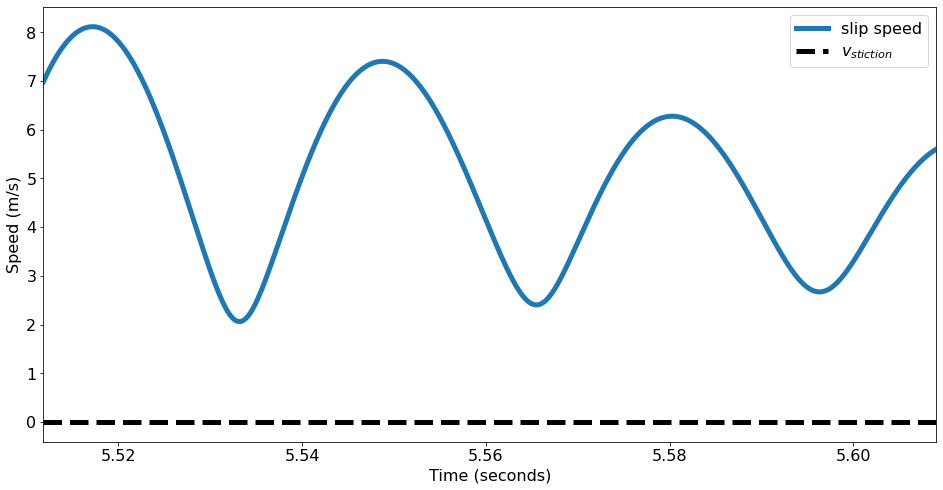

In [145]:
lw=5
plt.figure(figsize=(16, 8))
plt.plot(l_times[idx_start:idx_end], slip_speed[idx_start:idx_end], label="slip speed", linewidth=5)
plt.axhline(v_stiction, linestyle="--", color="k", label="$v_{stiction}$", linewidth=5)
plt.xlabel("Time (seconds)")
plt.ylabel("Speed (m/s)")
# plt.ylim(0, 2*v_stiction)
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.show()

## Joint torques

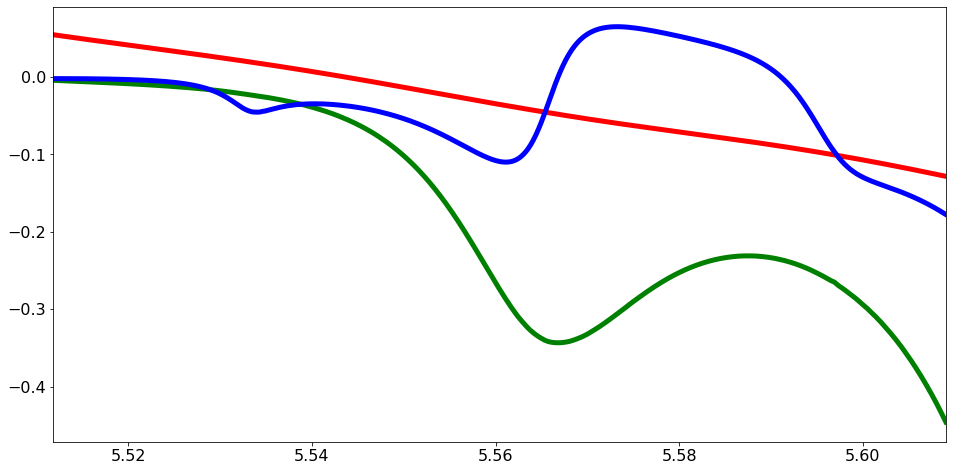

In [146]:
plt.figure(figsize=(16,8))
plt.plot(l_times[idx_start:idx_end], 
         joint_torque_in_compliance_frame[0,idx_start:idx_end], linewidth=5, color='r', label=r"\tau_x")
plt.plot(l_times[idx_start:idx_end], 
         joint_torque_in_compliance_frame[1,idx_start:idx_end], linewidth=5, color='g', label=r"\tau_y")
plt.plot(l_times[idx_start:idx_end], 
         joint_torque_in_compliance_frame[2,idx_start:idx_end], linewidth=5, color='b', label=r"\tau_z")
plt.autoscale(enable=True, axis='x', tight=True)

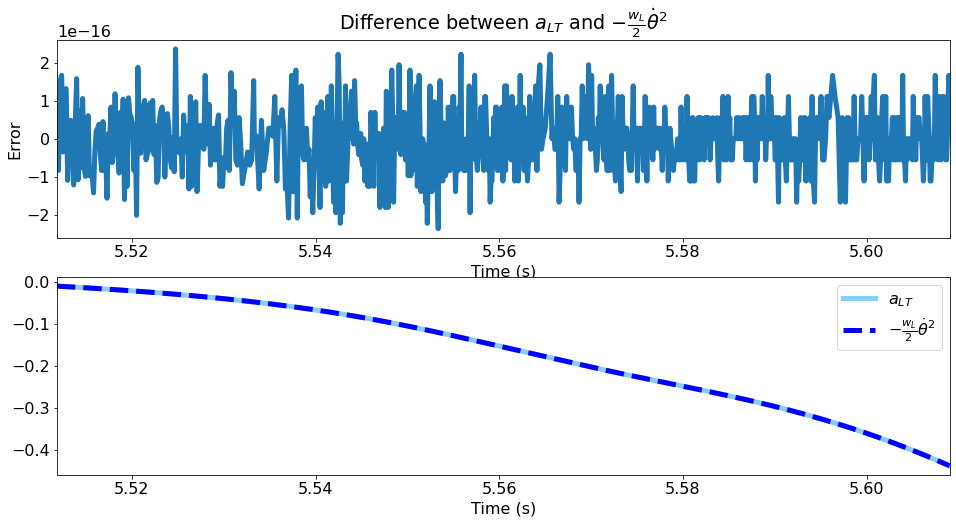

In [147]:
lhs = a_LT
lhs_label = r"$a_{LT}$"
rhs = (-w_L/2)*d_theta_L**2
rhs_label = r"$-\frac{w_L}{2}\dot\theta^2$"
plot_eq(lhs, lhs_label, rhs, rhs_label)

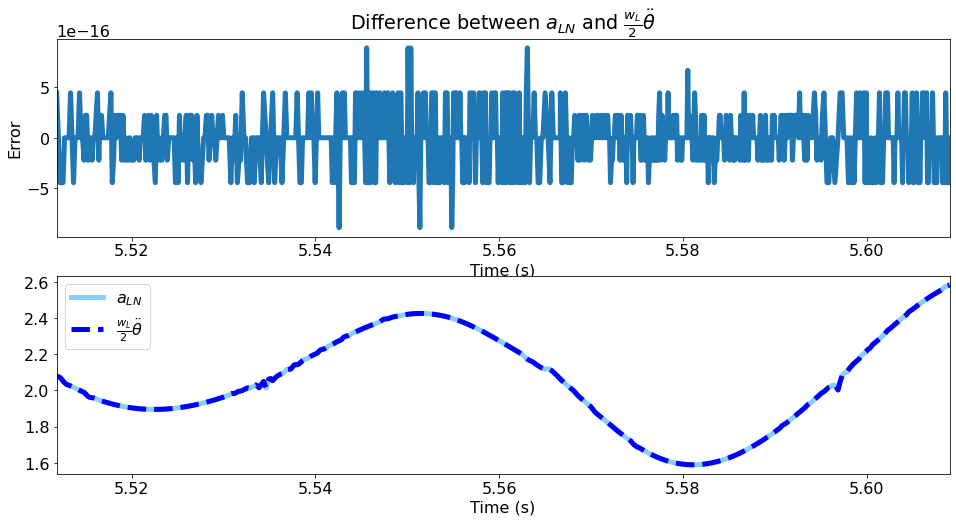

In [148]:
lhs = a_LN
lhs_label = r"$a_{LN}$"
rhs = (w_L/2)*dd_theta_L
rhs_label = r"$\frac{w_L}{2}\ddot\theta$"
plot_eq(lhs, lhs_label, rhs, rhs_label)

## Sliding surface variable

In [149]:
s = fold_ctrl.lamda*(d_T - fold_ctrl.d_Td) + (d_d_T)

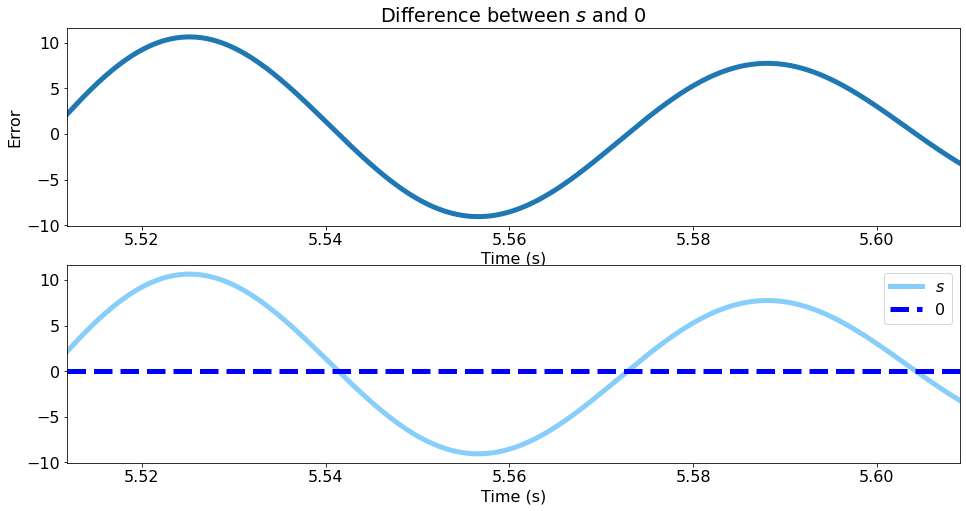

In [150]:
plot_eq(s, "$s$", 0, "0")

# Contact normal

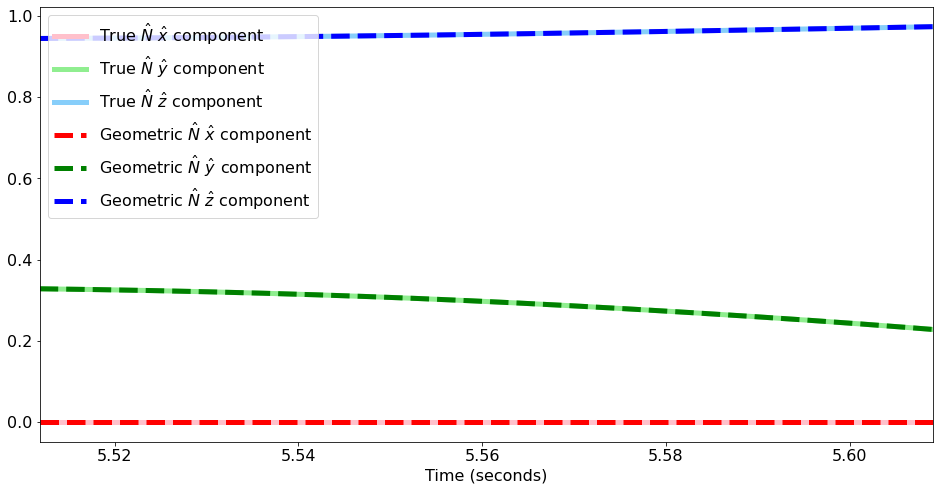

In [151]:
plot_vec(N_hat, r"True $\hat N$", N_hat_geo, r"Geometric $\hat N$")

# Debugging

In [152]:
for a, b in fold_ctrl.contacts[np.argmax(d_times > 7)]:
    name_a = plant.get_body(BodyIndex(a)).name()
    name_b = plant.get_body(BodyIndex(b)).name()
    print("{} in contact with {}".format(name_a, name_b))